<a href="https://colab.research.google.com/github/Lorddickenstein/FSLRwithNLP/blob/main/Application/Organize_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Organizing the Datasets
This program will organize the dataset from the Raw_Dataset folder in Colab Notebooks/Datasets/OurDataset/Raw_Dataset and put them in Colab Notebooks/Datgasets/OurDataset/Raw_Dataset_Renamed.

# Preprocessing and Renaming the Datasets
The program will copy all the files extracting only the located hand images, extracting the hand from the background using skin segmentation,resizing the images into 224x224, and renaming the images to their class name.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe==0.8.8

     |████████████████████████████████| 30.1 MB 13 kB/s 


In [ ]:
import os
import cv2
import mediapipe as mp
import numpy as np
import glob
import warnings
import random
import shutil
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
class HandDetector():
    def __init__(self, mode=False, maxHands=2, detectionConf=0.5, trackingConf=0.5):
        # Arguments
        self.mode = mode
        self.maxHands = maxHands
        self.detectionConf = detectionConf
        self.trackingConf = trackingConf

        # Initialize mediapipe variables
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(self.mode, self.maxHands,
                                        self.detectionConf, self.trackingConf)
        self.mpDraw = mp.solutions.drawing_utils


    def find_hands(self, src_img, draw=False):
        # Convert frame to rgb for mediapipe
        rgb = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        rgb.flags.writeable = False
        self.results = self.hands.process(rgb)

        if self.results.multi_hand_landmarks:
            x_pts, y_pts = [], []
            for handLMs in self.results.multi_hand_landmarks:
                for id, lm in enumerate(handLMs.landmark):
                    h, w, c = src_img.shape
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    x_pts.append(cx)
                    y_pts.append(cy)
                if draw:
                    self.mpDraw.draw_landmarks(src_img, handLMs, self.mpHands.HAND_CONNECTIONS)

            if i == 21 or i == 42:
              # Find the max and min points
              y_max, y_min, x_max, x_min = max(y_pts), min(y_pts), max(x_pts), min(x_pts)
              extra_space = src_img.shape[0] * 0.10 if src_img.shape[0] < src_img.shape[1] else src_img.shape[1] * 0.10
              return True, (int(x_min - extra_space), int(y_max + extra_space)), (int(x_max + extra_space), int(y_min - extra_space))

        return False, (), ()

## Functions
Contains all the functions that are needed for this program.

In [ ]:
# Show image in matplotlib
def show_plt_image(src_img):
    plt.imshow(src_img, cmap='gray')
    plt.show()

In [ ]:
# Creates a directory for every enumerable class_obj
def make_dir(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    os.makedirs(path_class)

In [ ]:
# Resize the image into 224x224
def resize_image(src_img, img_size=(224, 224)):
  return cv2.resize(src_img, img_size, interpolation=cv2.INTER_CUBIC)

In [ ]:
# Returns an image with morphological transformation using MORPH_CLOSE
def morph_image(src_img, method=cv2.MORPH_CLOSE, kernel=(5, 5)):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel)
    return cv2.morphologyEx(src_img, method, kernel)

In [ ]:
# Returns a masked image showing only the skin range values in the YCrCb colorspace
def skin_segmentation(src_img):
    # YCrCb pixel upper and lower boundaries
    YCbCr_lower = np.array([0, 135, 80], np.uint8)
    YCbCr_upper = np.array([255, 180, 135], np.uint8)

    # Convert bgr to YCbCr color space
    img_YCbCr = cv2.cvtColor(src_img, cv2.COLOR_BGR2YCrCb)

    # Determine the intensities of YCbCr pixel intensities that fall inside the upper and lower boundaries
    YCrCb_mask = cv2.inRange(img_YCbCr, YCbCr_lower, YCbCr_upper)

    # Apply open morphological transformation
    YCrCb_mask = morph_image(YCrCb_mask, method=cv2.MORPH_OPEN, kernel=(5, 5))

    # Apply close morphological transformation
    YCrCb_mask = morph_image(YCrCb_mask, method=cv2.MORPH_CLOSE, kernel=(9, 9))

    # Apply Dilation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    YCrCb_mask = cv2.dilate(YCrCb_mask, kernel, iterations=2)

    # Blur image to lessen noise
    YCrCb_mask_blur = cv2.medianBlur(YCrCb_mask, 21)

    show_plt_image(YCrCb_mask_blur)

    # Apply mask to the frame
    return cv2.bitwise_and(src_img.copy(), src_img.copy(), mask=YCrCb_mask_blur)

In [ ]:
# Counts all the images that is located in path for every enumerable class_obj
def count_items(path, class_obj):
  for obj in class_obj:
    path_class = os.path.join(path, obj)
    # print(path_class)
    print(obj, len(os.listdir(path_class)))

# Class Counter
Counts the number of classes in each category.

In [ ]:
path_raw = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset'
for item in os.listdir(path_raw):
  category = os.path.join(path_raw, item)
  ctr = 0
  for obj in os.listdir(category):
    ctr += 1
  print("{} has {} classes.".format(item, ctr))


Letters has 26 classes.
Numbers has 9 classes.
Dynamic Single has 23 classes.
Dynamic Double has 55 classes.
Static Double has 14 classes.
Static Single has 13 classes.


## Path and Variable Configurations

In [ ]:
dataset_raw = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset'
dataset_preprocessed = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Preprocessed_Raw_Dataset'

In [ ]:
# Organize data into train, valid, test dirs
dataset_categories = ['Dynamic_Single', 'Dynamic_Double',
                       'Static_Single', 'Static_Double',
                       'Letters', 'Numbers']

letters = ['A', 'B', 'C', 'D', 'E',
           'F', 'G', 'H', 'I', 'J',
           'K', 'L', 'M', 'N', 'O',
           'P', 'Q', 'R', 'S', 'T',
           'U', 'V', 'W', 'X', 'Y',
           'Z']

numbers = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

static_single = ['Fine', 'Gabi', 'Good', 'Hapon', 'He-She',
                 'His-Her', 'I Love You', 'I-Me', 'Mine',
                 'Tanghali', 'Umaga', 'You', 'Your']

static_double = ['Congratulations', 'Great', 'Help', 'Meet', 'Table',
                 'Name', 'Occupation', 'Pray', 'Rest', 'Pen',
                 'Stand', 'Study', 'To', 'Chair']

dynamic_single = ['Eroplano', 'Eroplano-2', 'Invite', 'Late', 'Late-2',
                  'No', 'No-2', 'Our', 'Our-2', 'Sorry', 'That', 'Them',
                  'This', 'We', 'Welcome', 'Welcome-2', 'When', 'Who',
                  'Who-2', 'Why', 'Why-2', 'Yes', 'Yesterday']

dynamic_double = ['Ago', 'Allow', 'Ball', 'Banana', 'Banana-2', 'Bread', 'Break', 'Egg',
                  'Break-2', 'Bring', 'Bring-2', 'Buy', 'Buy-2', 'Bye', 'Coconut', 'Egg-2',
                  'Coffee', 'Come', 'Come-2', 'Cook', 'From', 'From-2', 'Get', 'Get-2', 'Egg-3',
                  'Go', 'Go-2', 'Happen', 'Happen-2', 'How', 'How-2', 'Introduce', 'Introduce-2',
                  'Let', 'Let-2', 'Live', 'Mango', 'Maybe', 'Nice', 'Now', 'Office', 'Office-2',
                  'School', 'Sit', 'Store', 'Strawberry', 'Thank You', 'Thank You-2', 'Today', 'Today-2',
                  'What', 'Where', 'Which', 'Work', 'Year']

dataset_classes = numbers + letters + static_single + static_double + dynamic_single + dynamic_double

In [ ]:
print(len(letters))
print(len(numbers))
print(len(static_single))
print(len(static_double))
print(len(dynamic_single))
print(len(dynamic_double))

26
9
13
14
23
55


In [ ]:
assert len(letters) == 26
assert len(numbers) == 9
assert len(static_single) == 13
assert len(static_double) == 14
assert len(dynamic_single) == 23
assert len(dynamic_double) == 55

## Create a directory for each category in Preprocessed Folder

In [ ]:
# Letters
dataset_preprocessed_letters = os.path.join(dataset_preprocessed, 'Letters')
if os.path.isdir(dataset_preprocessed_letters) is False:
  make_dir(dataset_preprocessed_letters, letters)
else:
  print('Path already exist')

Path already exist


In [ ]:
# Numbers
dataset_preprocessed_numbers = os.path.join(dataset_preprocessed, 'Numbers')
if os.path.isdir(dataset_preprocessed_numbers) is False:
  make_dir(dataset_preprocessed_numbers, numbers)
else:
  print('Path already exist')

Path already exist


In [ ]:
# Static Single
dataset_preprocessed_static_single = os.path.join(dataset_preprocessed, 'Static Single')
if os.path.isdir(dataset_preprocessed_static_single) is False:
  make_dir(dataset_preprocessed_static_single, static_single)
else:
  print('Path already exist')

Path already exist


In [ ]:
# Static Double
dataset_preprocessed_static_double = os.path.join(dataset_preprocessed, 'Static Double')
if os.path.isdir(dataset_preprocessed_static_double) is False:
  make_dir(dataset_preprocessed_static_double, static_double)
else:
  print('Path already exist')

Path already exist


In [ ]:
# Dynamic Single
dataset_preprocessed_dynamic_single = os.path.join(dataset_preprocessed, 'Dynamic Single')
if os.path.isdir(dataset_preprocessed_dynamic_single) is False:
  make_dir(dataset_preprocessed_dynamic_single, dynamic_single)
else:
  print('Path already exist')

Path already exist


In [ ]:
# Dynamic Double
dataset_preprocessed_dynamic_double = os.path.join(dataset_preprocessed, 'Dynamic Double')
if os.path.isdir(dataset_preprocessed_dynamic_double) is False:
  make_dir(dataset_preprocessed_dynamic_double, dynamic_double)
else:
  print('Path already exist')

Path already exist


## Extract Frame from videos in the dataset
Dynamic gestures are stored in video clips. Extract those frames using

## Preprocessing Steps
1. Take the images from Raw_Dataset.
2. Crop the hands from each images.
3. Apply skin-segmentation to extract hands from background.
4. Transform images to grayscale.
5. Save the images to Preprocessed_Raw_Dataset.
6. Rename images from 0 to N number of images.

In [ ]:
detector = HandDetector()

In [ ]:
# Letters
dataset_raw_letters = os.path.join(dataset_raw, 'Letters')
dataset_raw_preprocessed_letters = os.path.join(dataset_preprocessed, 'Letters')
for letter in letters:
  path_class = os.path.join(dataset_raw_letters, letter)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_letters, letter)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = letter + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1


In [ ]:
# Numbers
dataset_raw_numbers = os.path.join(dataset_raw, 'Numbers')
dataset_raw_preprocessed_number = os.path.join(dataset_preprocessed, 'Numbers')
for number in numbers:
  path_class = os.path.join(dataset_raw_numbers, number)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_number, number)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = number + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Static Single
dataset_raw_ss = os.path.join(dataset_raw, 'Static Single')
dataset_raw_preprocessed_ss = os.path.join(dataset_preprocessed, 'Static Single')
for sign in static_single:
  path_class = os.path.join(dataset_raw_ss, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_ss, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Static Double
dataset_raw_sd = os.path.join(dataset_raw, 'Static Double')
dataset_raw_preprocessed_sd = os.path.join(dataset_preprocessed, 'Static Double')
for sign in static_double:
  path_class = os.path.join(dataset_raw_sd, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_sd, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

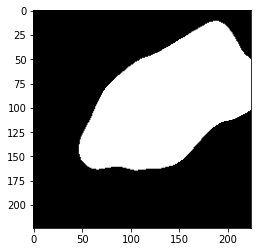

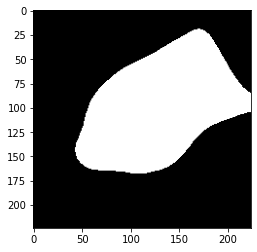

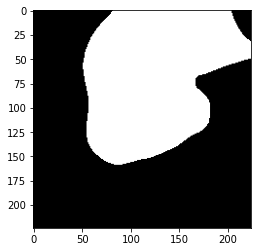

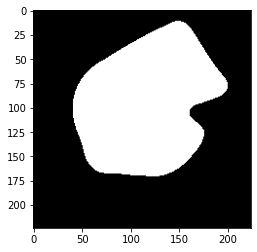

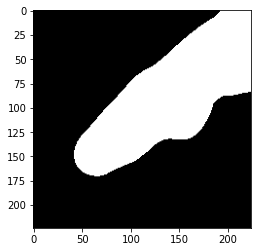

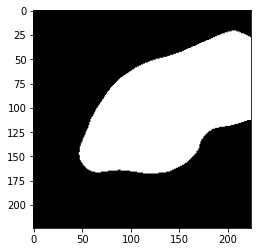

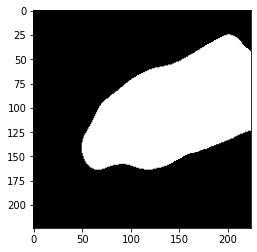

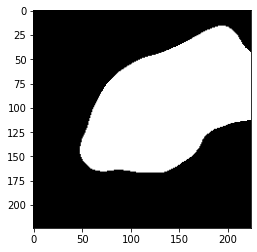

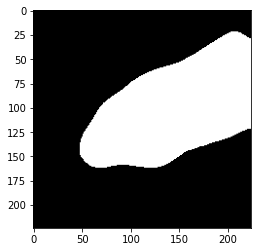

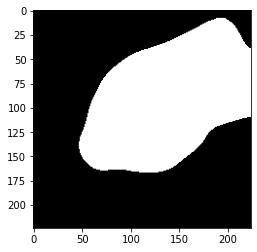

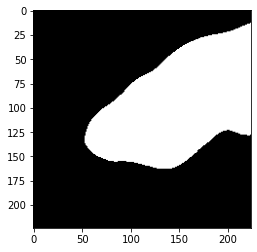

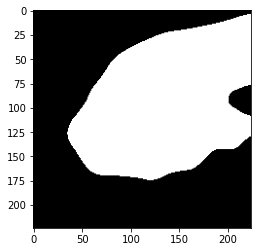

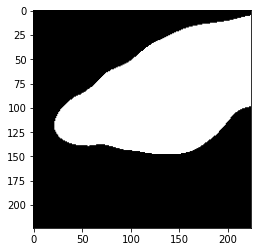

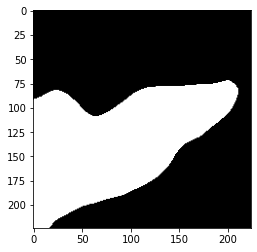

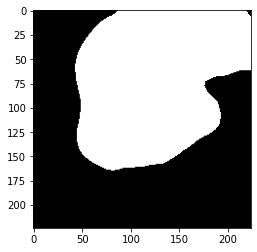

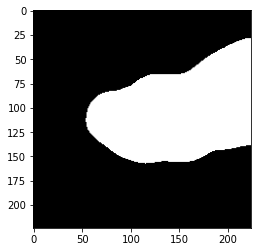

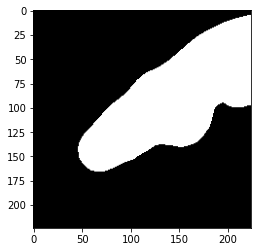

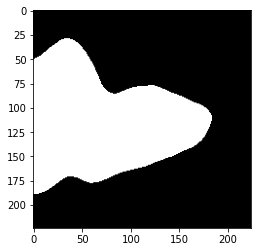

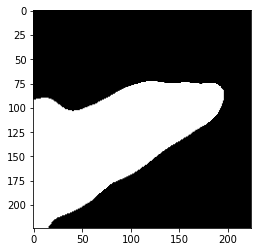

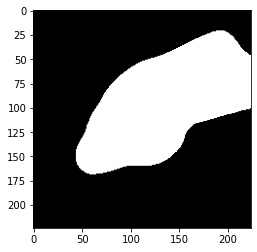

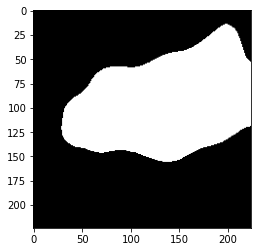

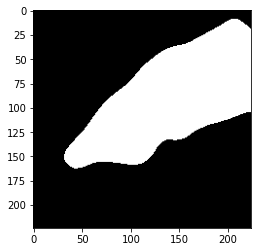

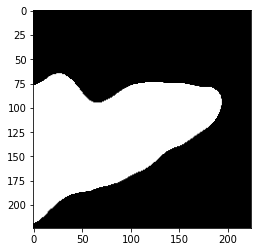

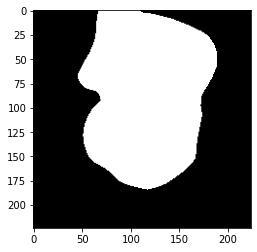

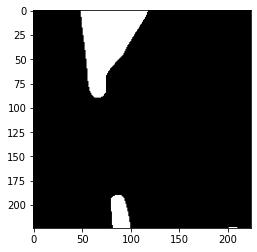

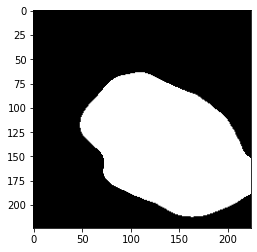

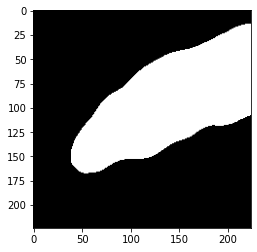

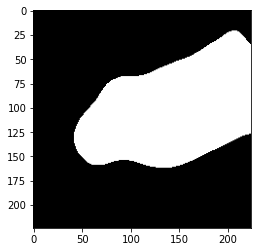

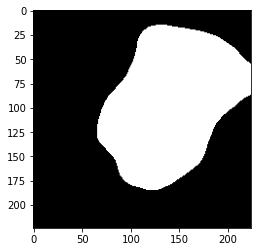

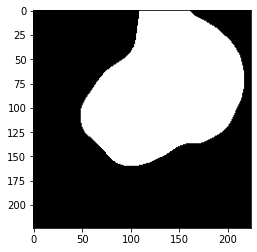

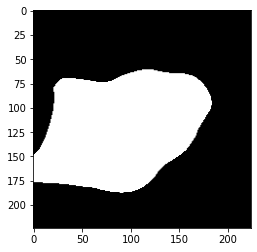

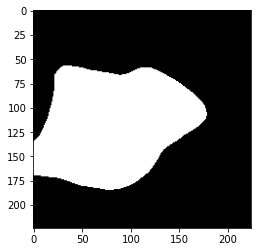

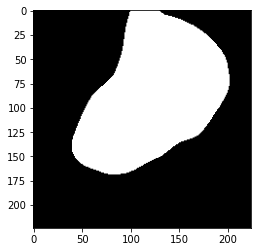

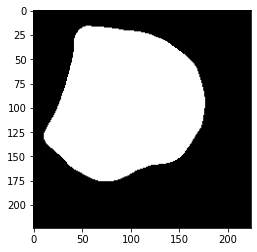

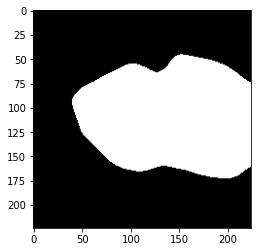

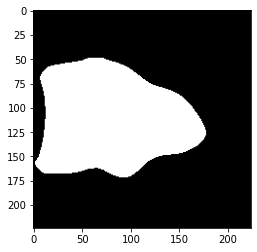

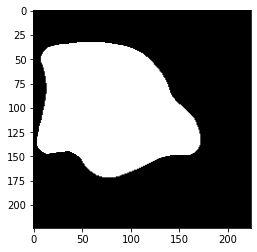

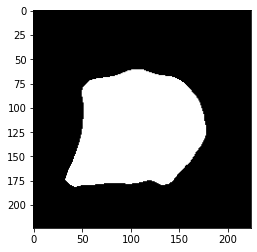

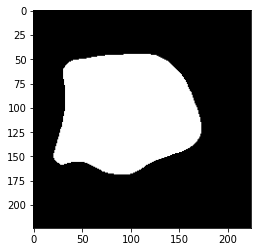

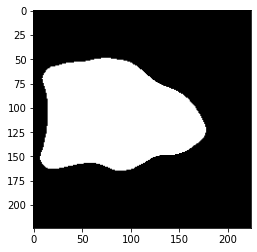

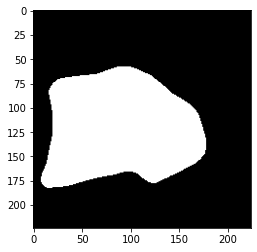

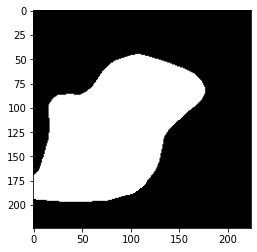

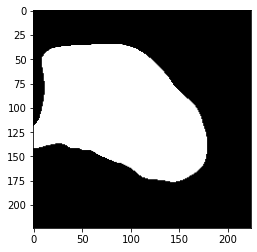

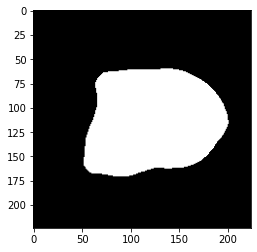

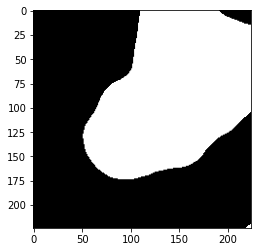

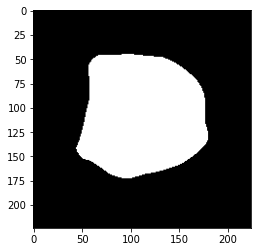

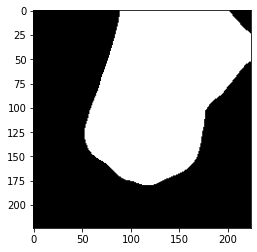

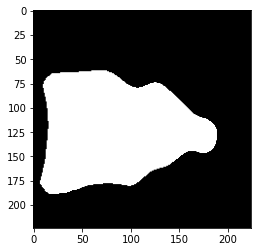

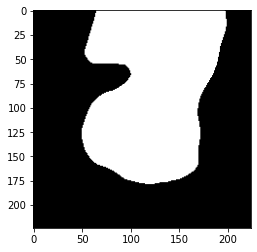

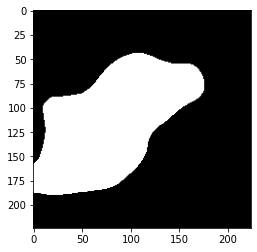

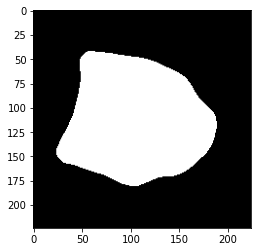

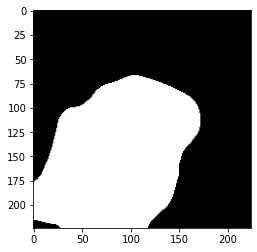

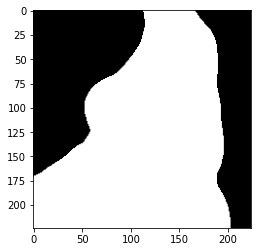

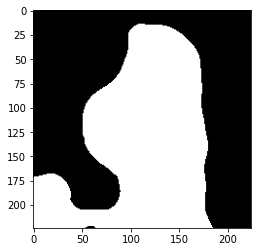

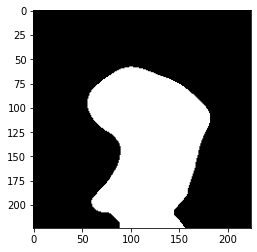

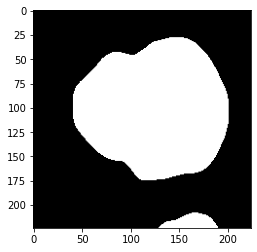

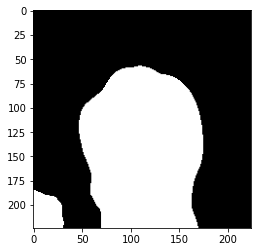

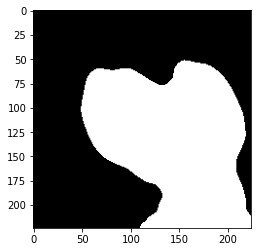

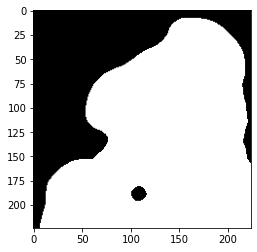

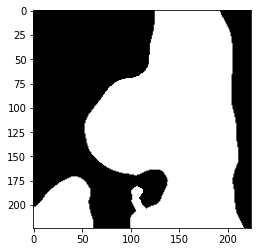

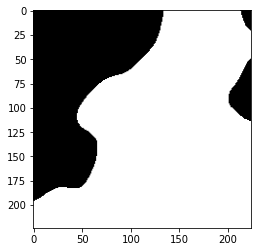

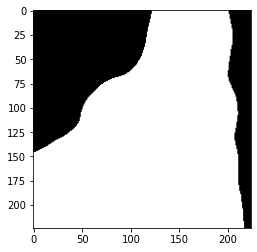

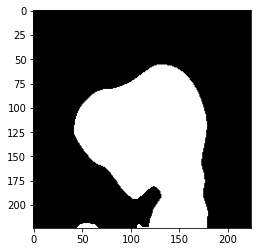

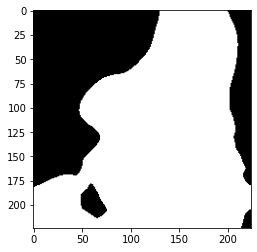

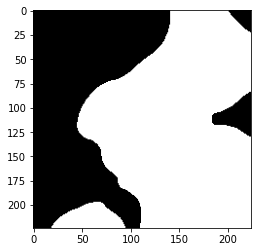

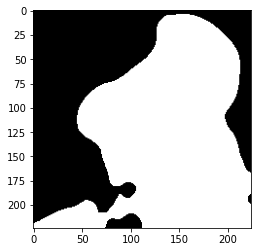

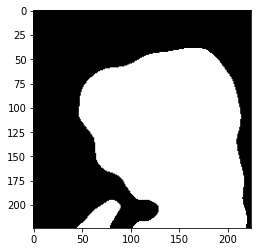

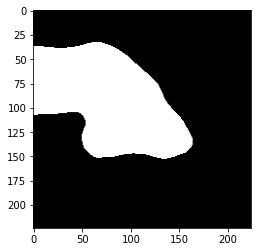

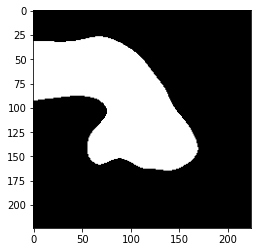

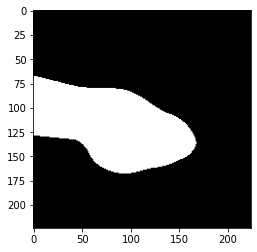

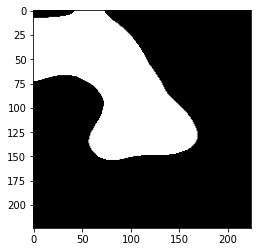

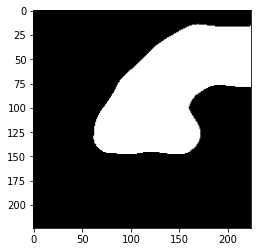

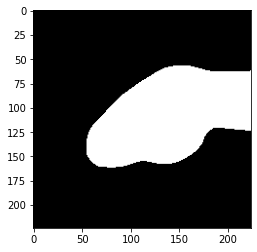

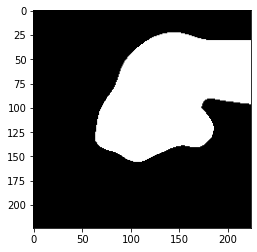

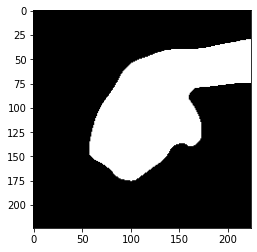

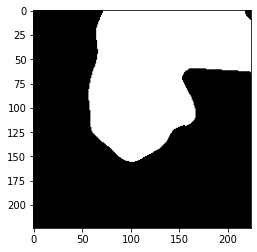

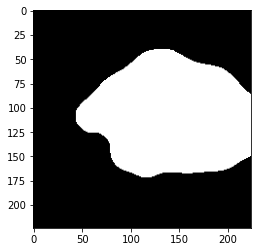

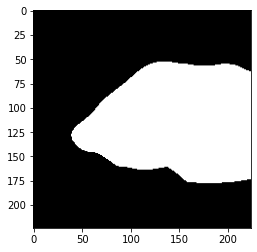

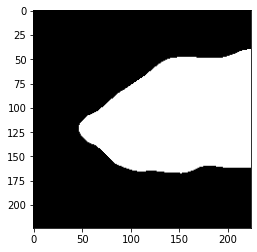

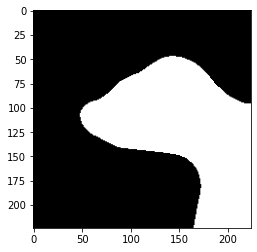

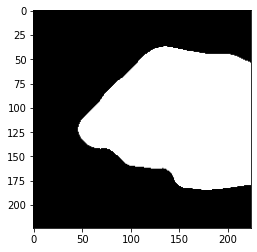

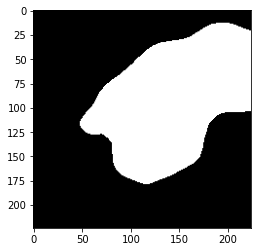

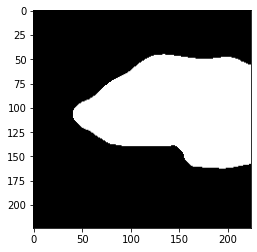

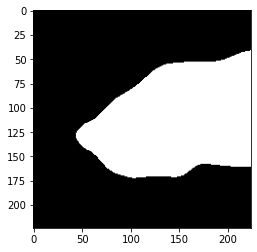

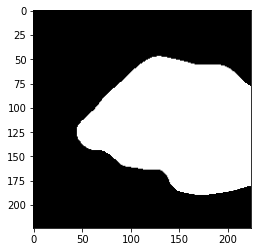

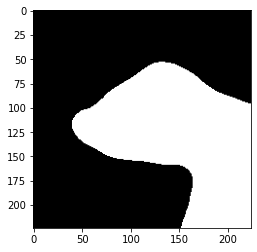

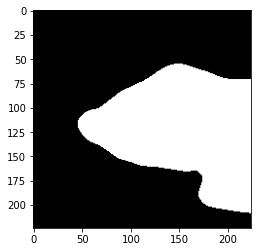

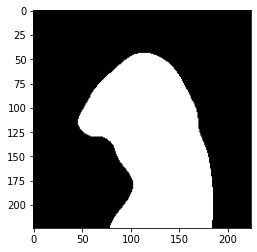

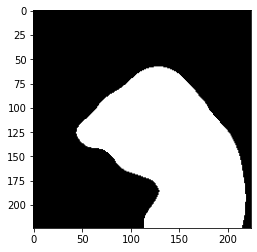

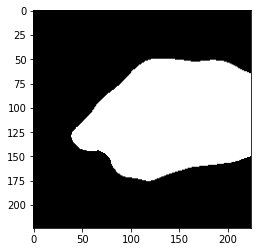

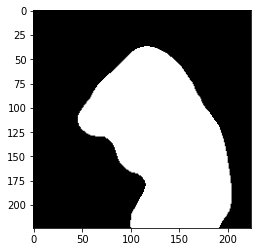

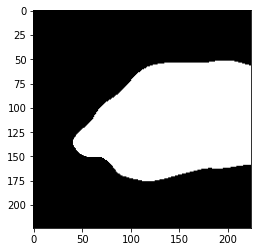

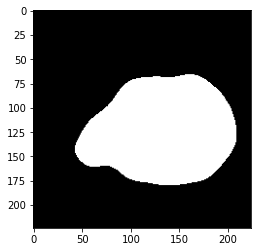

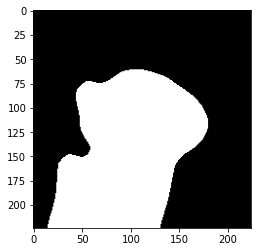

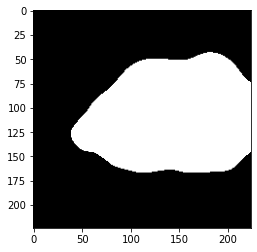

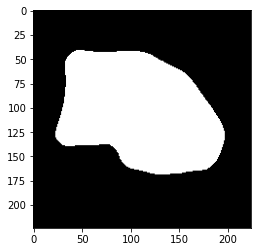

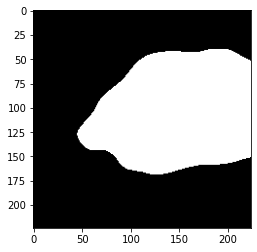

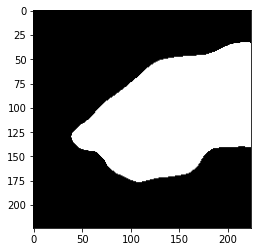

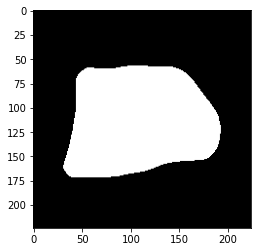

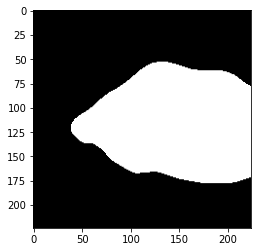

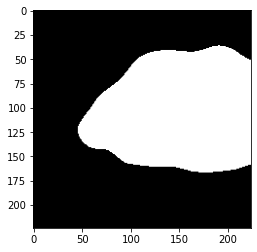

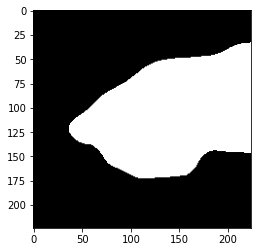

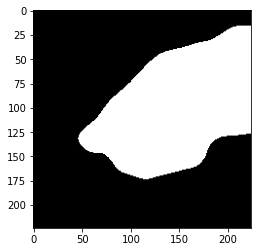

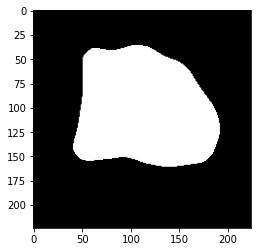

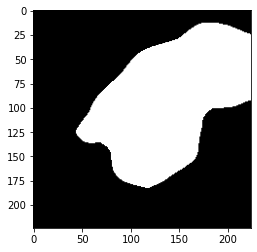

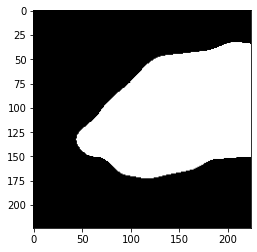

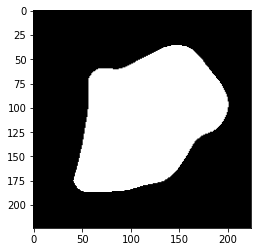

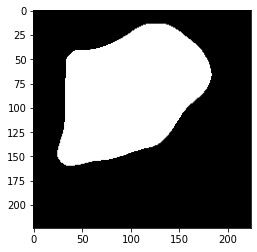

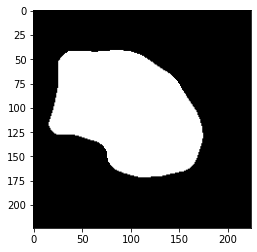

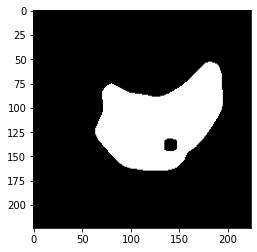

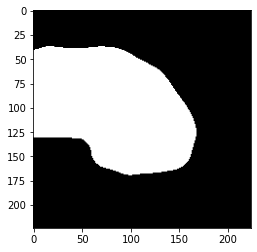

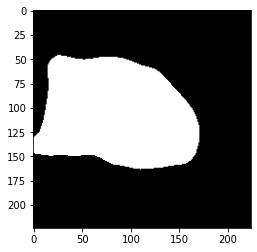

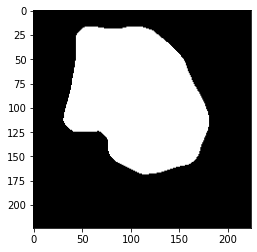

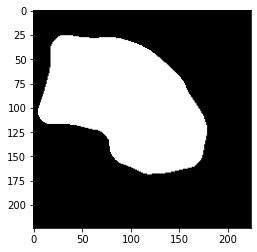

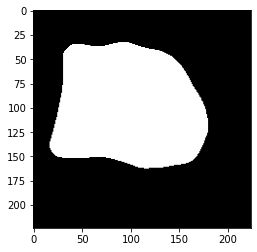

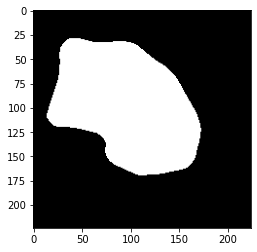

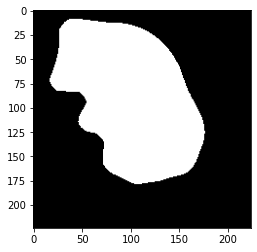

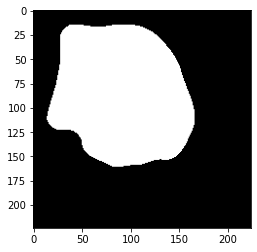

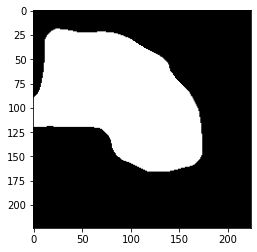

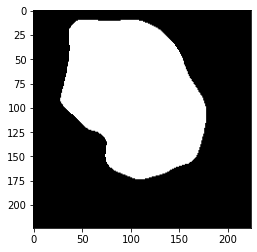

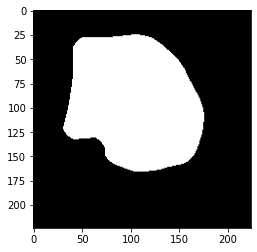

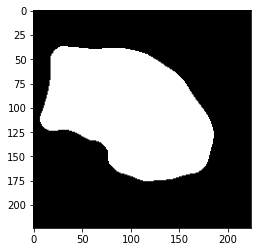

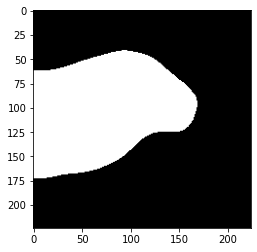

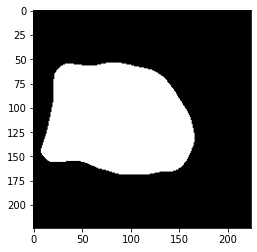

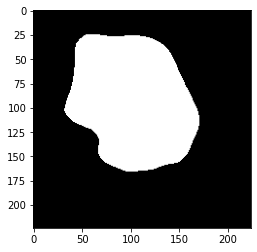

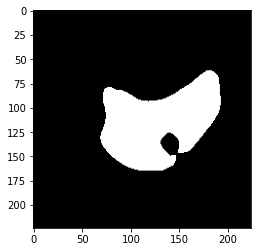

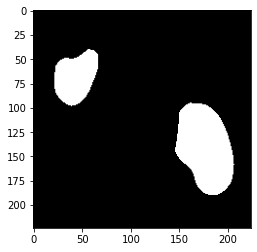

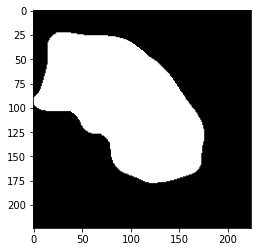

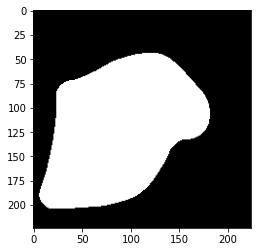

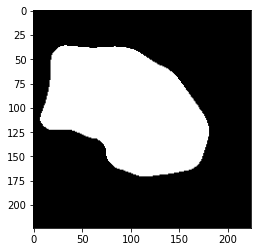

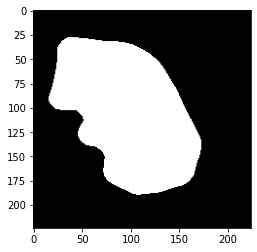

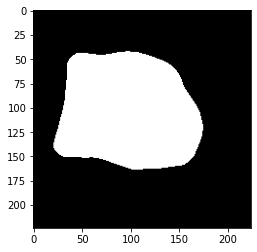

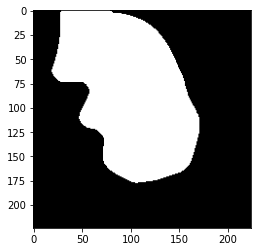

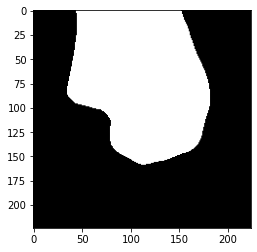

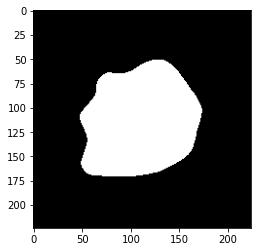

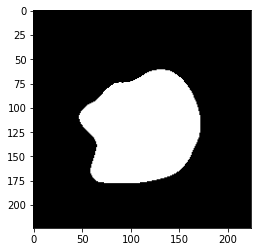

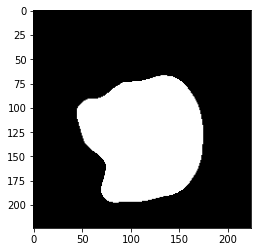

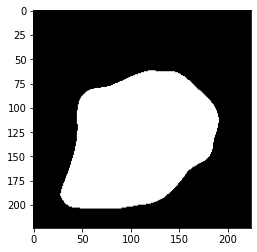

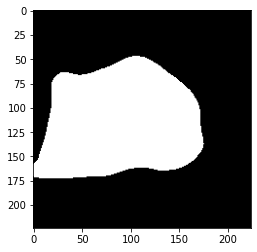

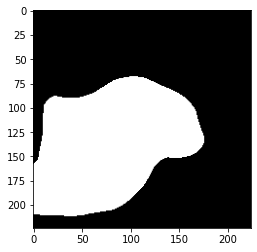

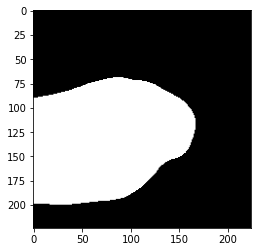

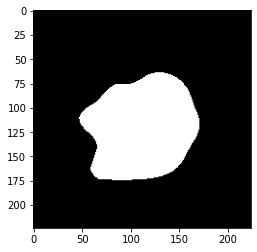

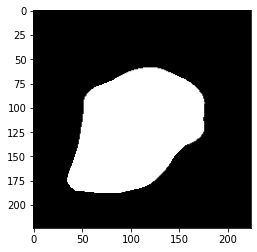

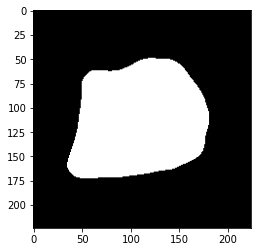

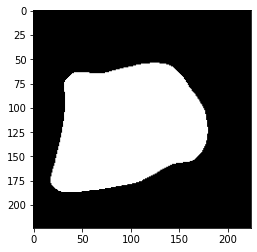

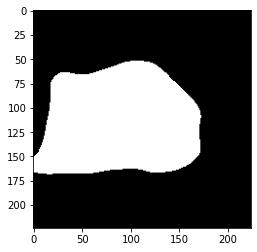

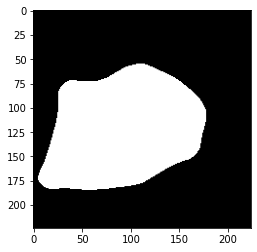

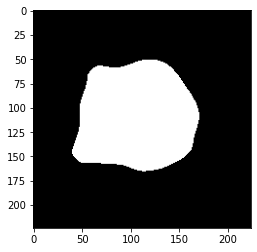

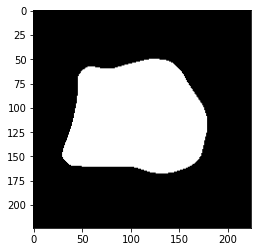

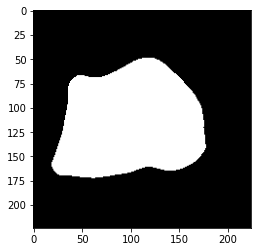

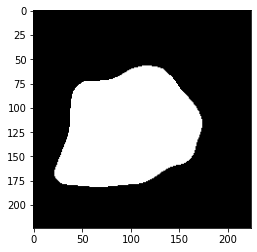

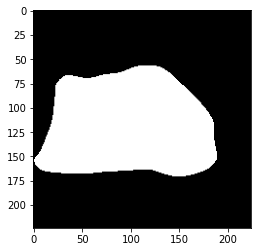

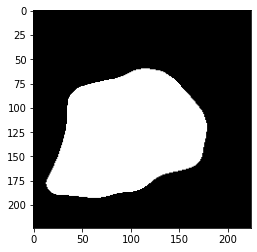

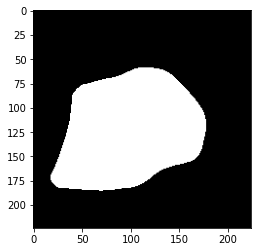

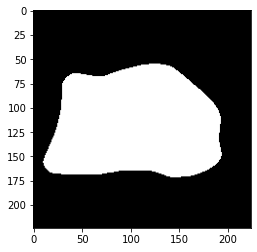

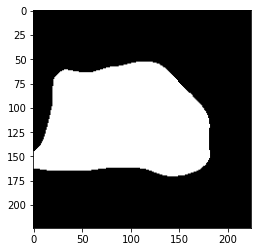

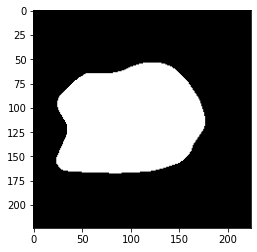

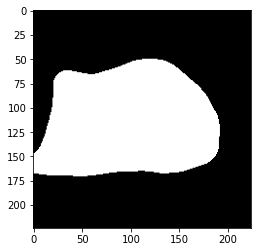

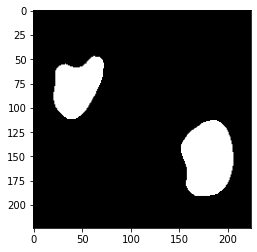

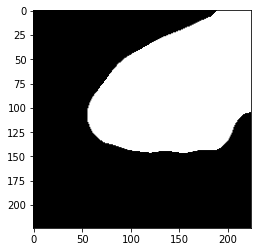

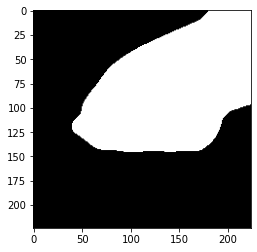

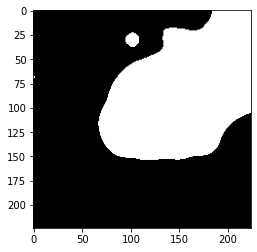

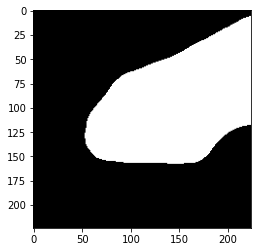

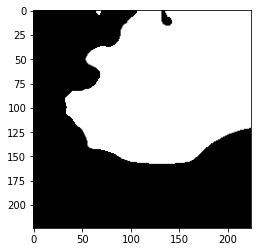

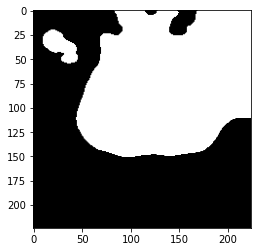

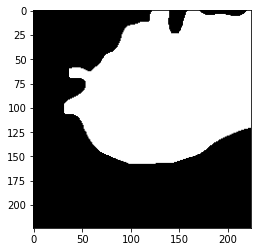

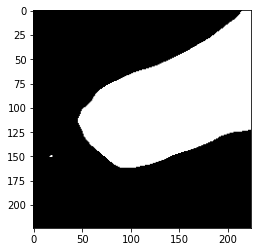

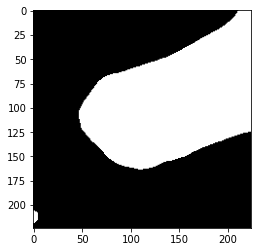

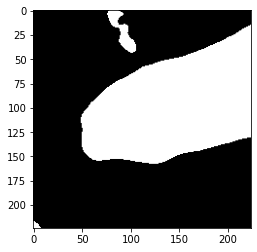

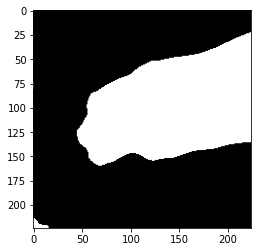

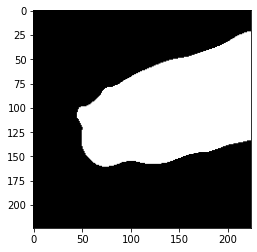

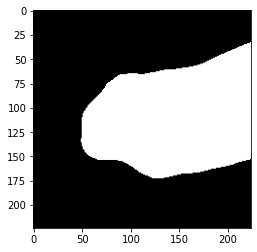

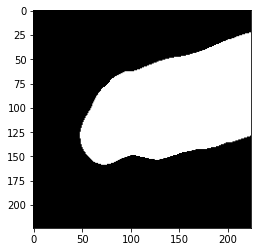

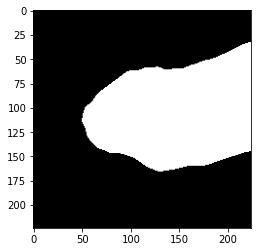

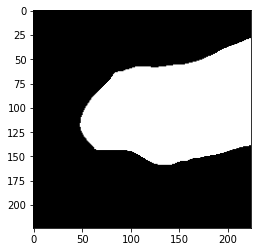

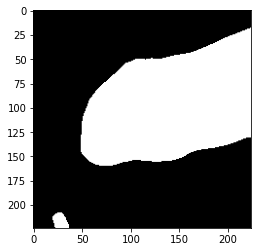

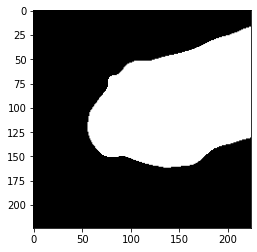

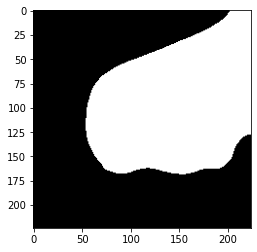

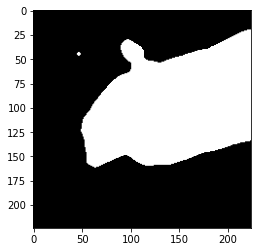

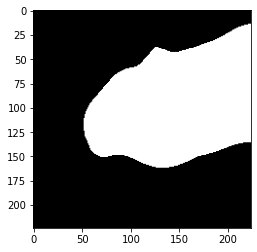

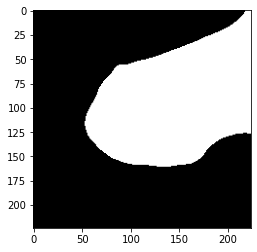

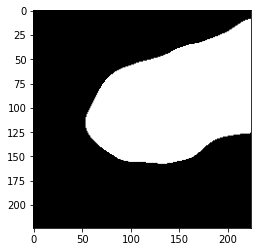

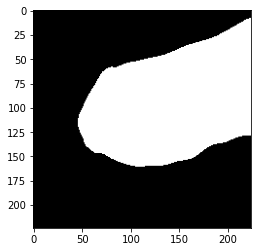

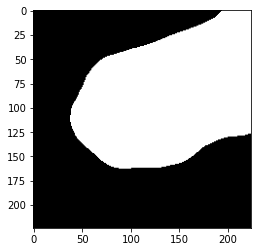

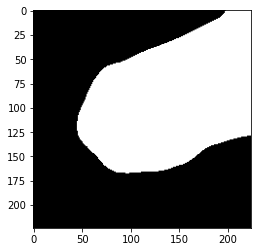

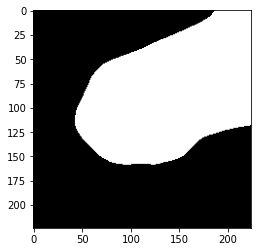

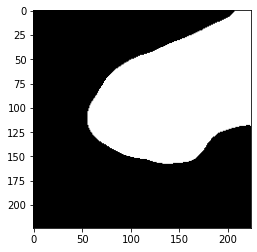

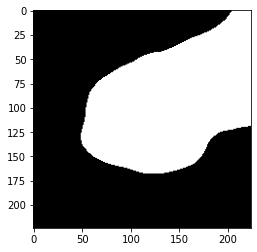

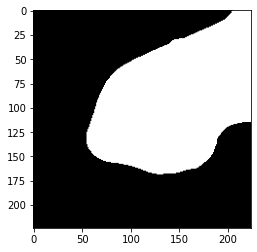

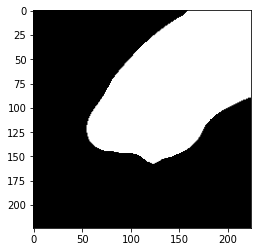

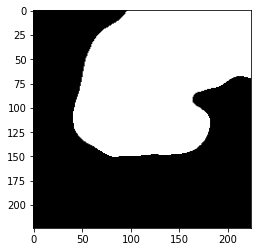

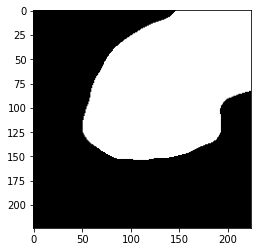

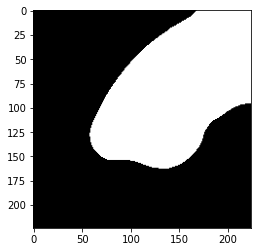

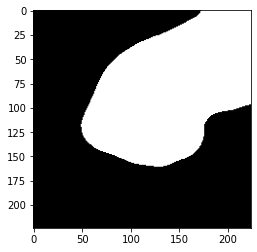

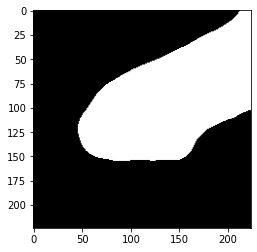

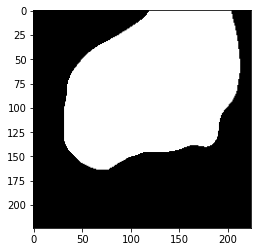

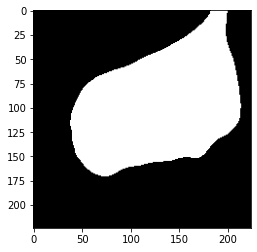

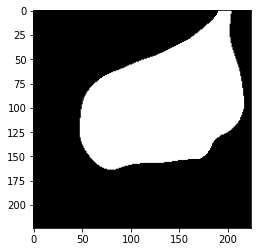

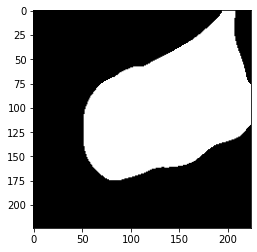

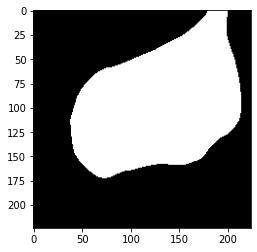

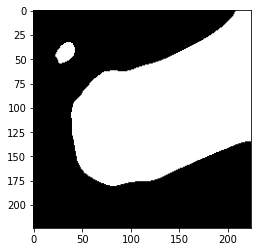

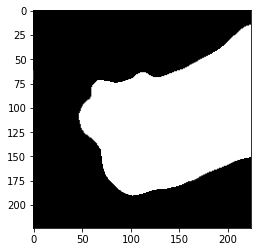

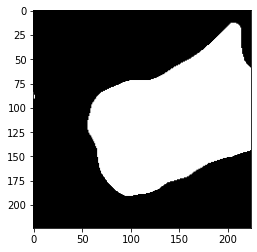

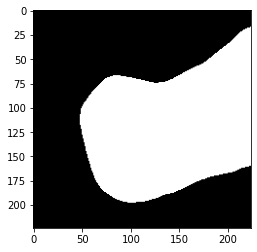

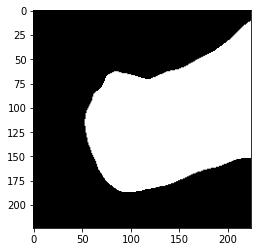

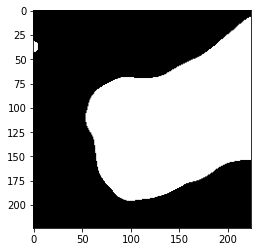

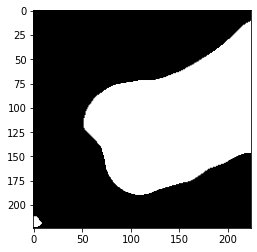

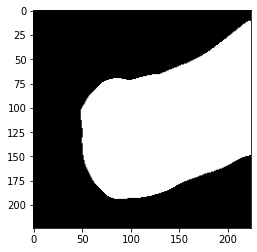

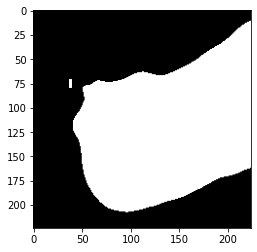

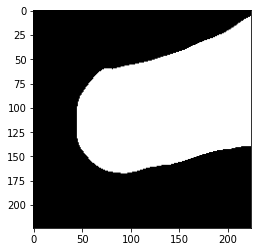

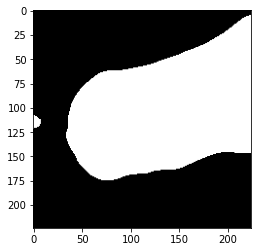

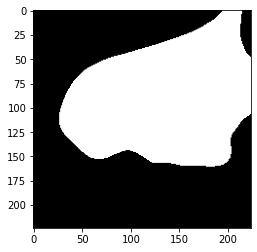

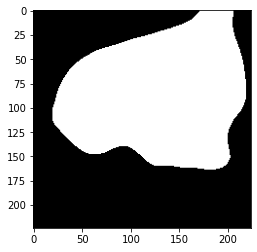

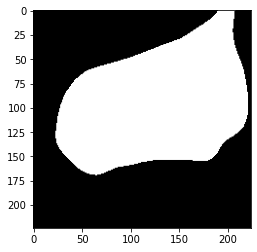

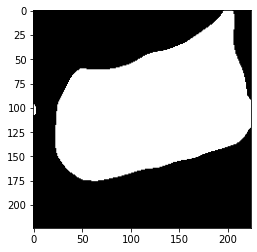

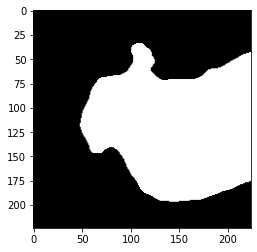

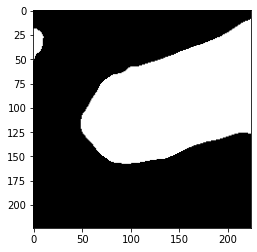

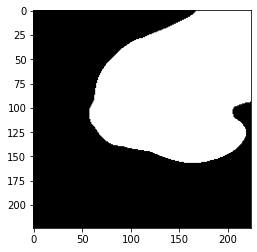

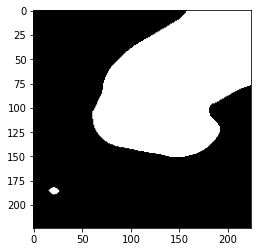

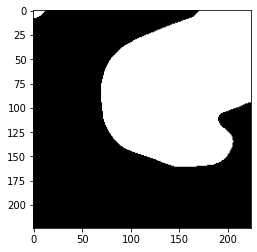

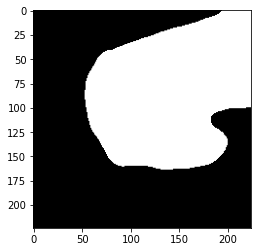

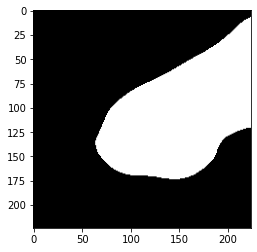

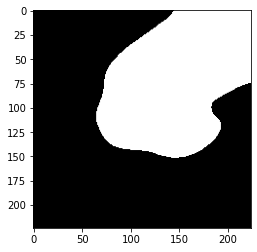

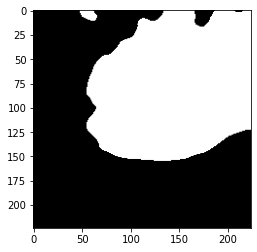

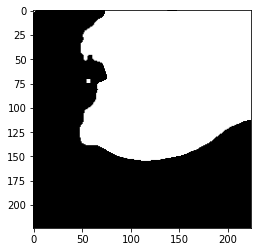

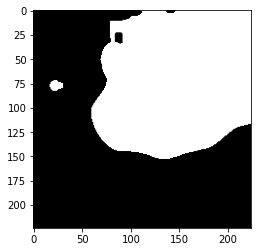

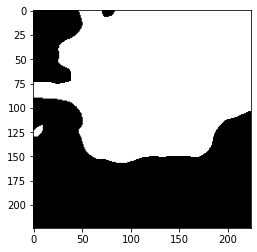

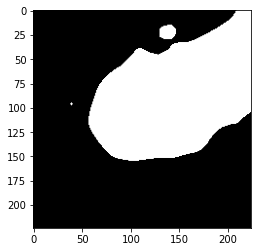

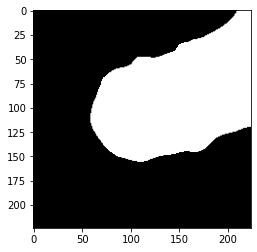

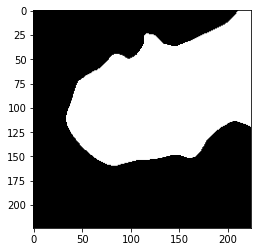

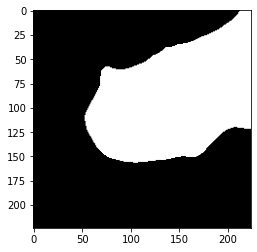

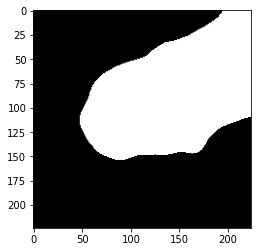

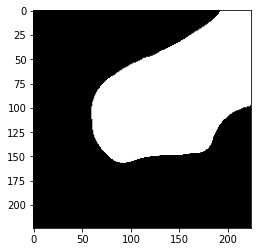

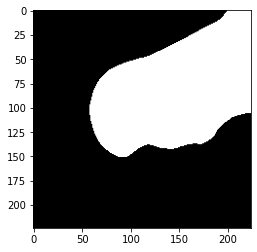

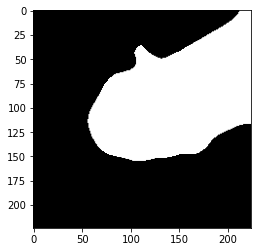

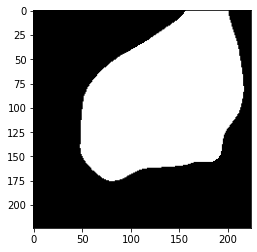

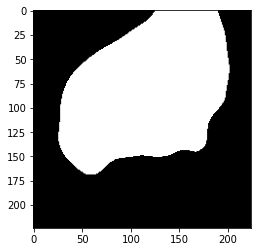

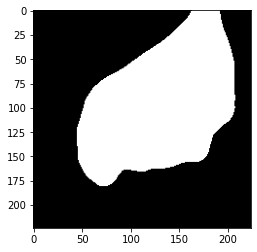

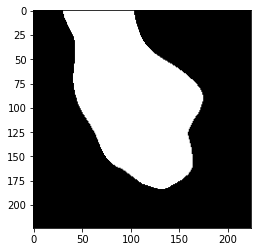

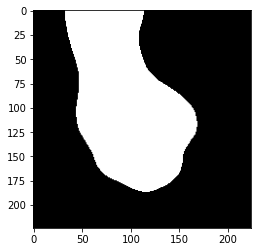

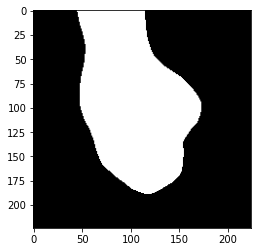

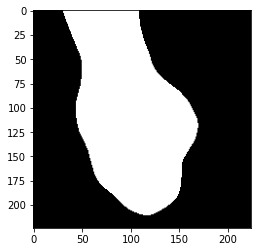

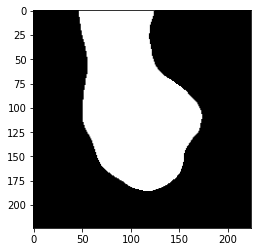

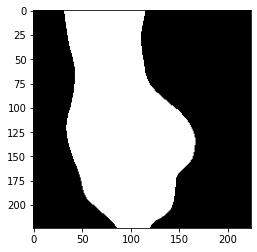

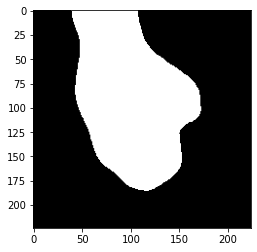

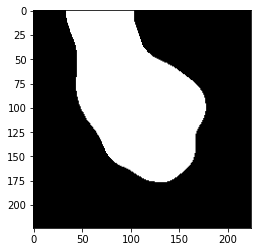

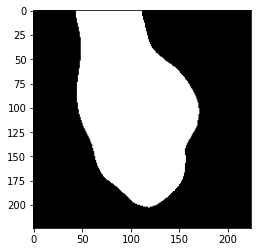

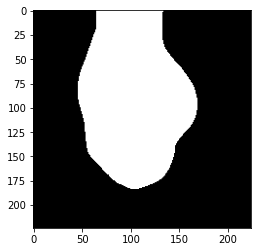

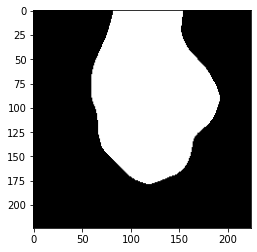

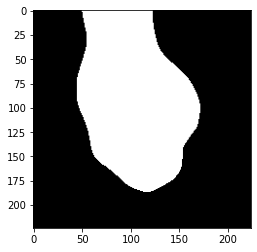

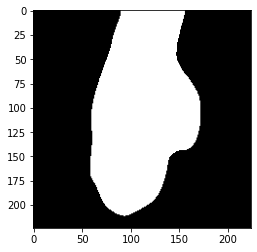

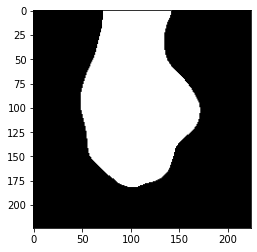

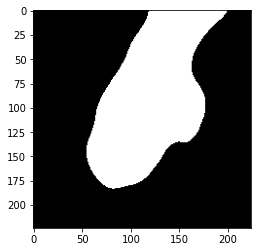

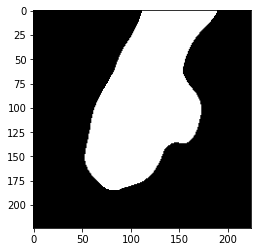

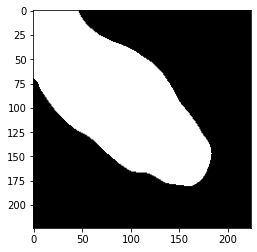

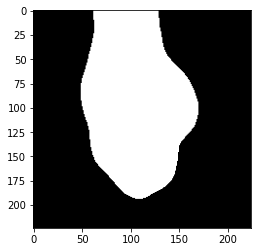

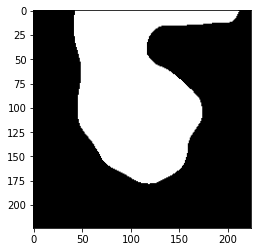

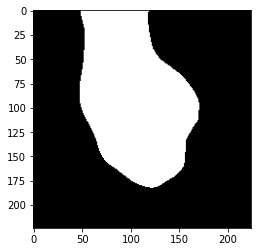

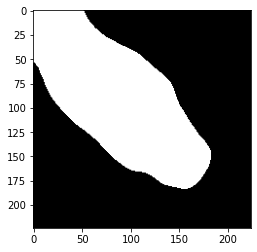

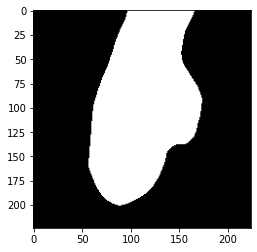

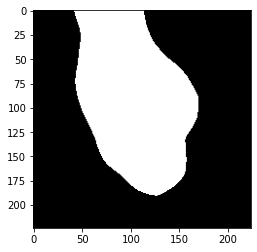

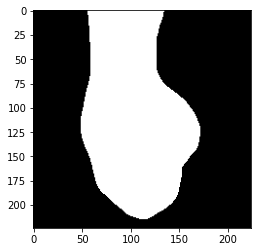

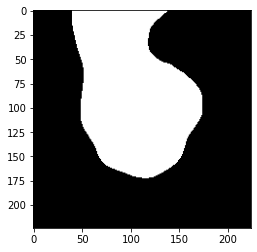

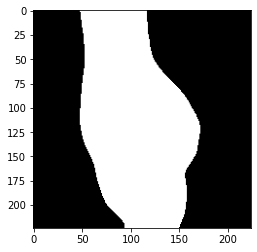

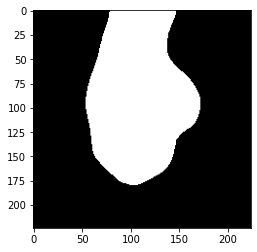

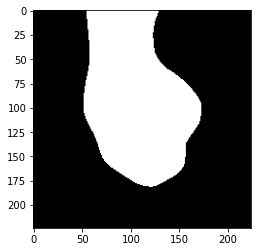

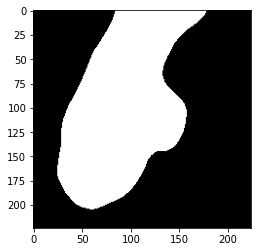

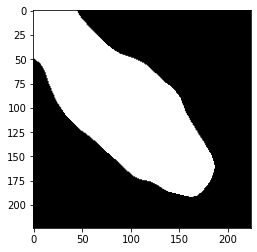

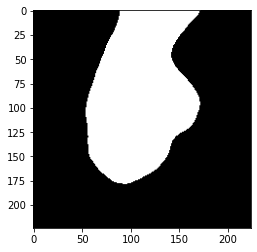

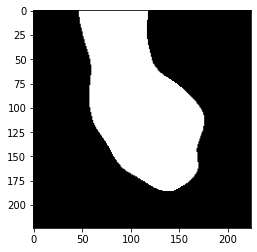

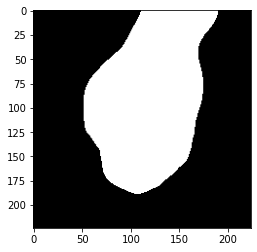

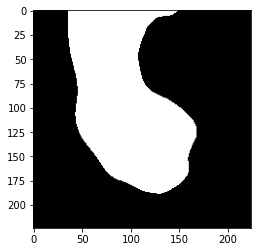

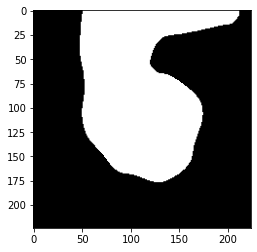

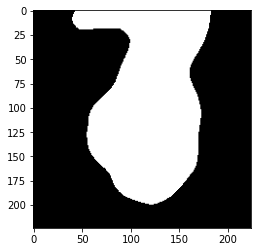

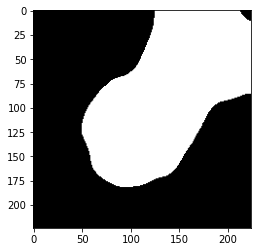

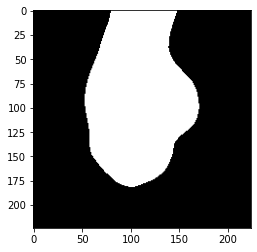

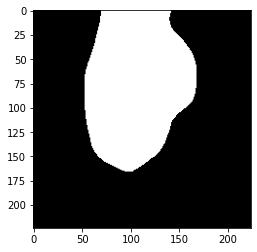

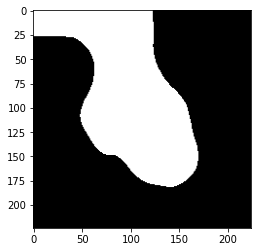

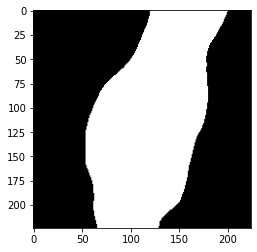

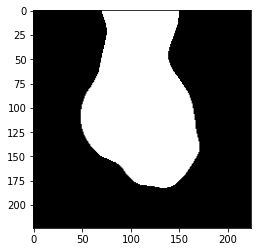

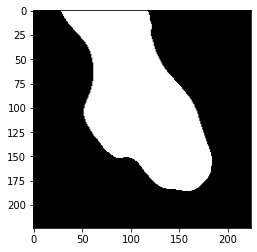

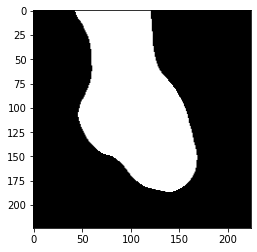

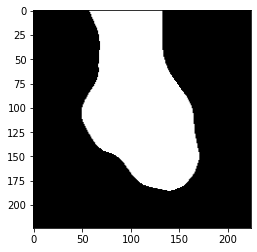

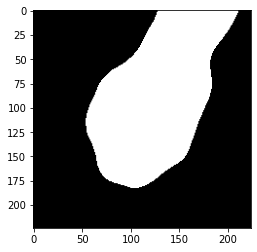

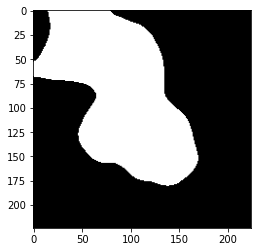

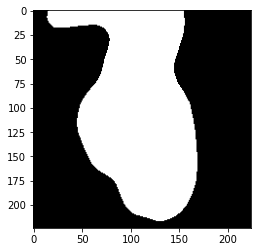

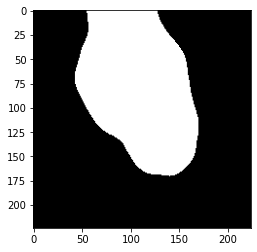

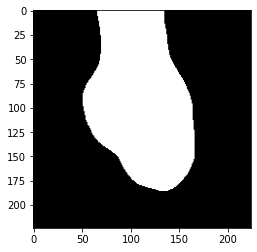

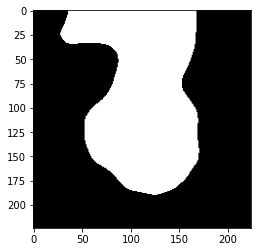

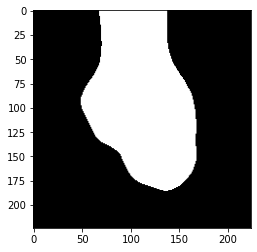

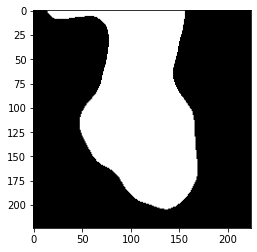

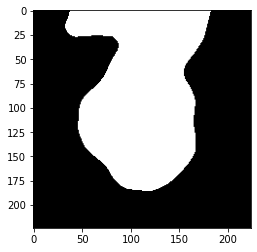

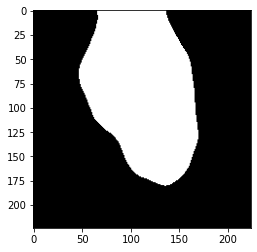

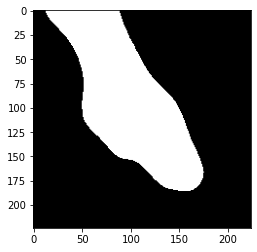

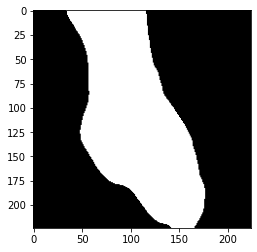

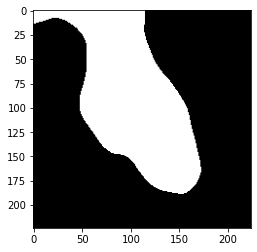

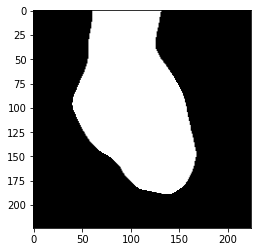

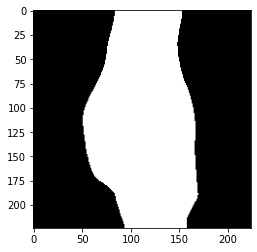

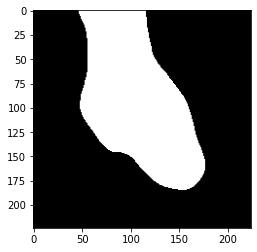

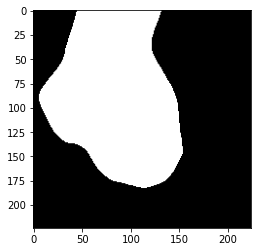

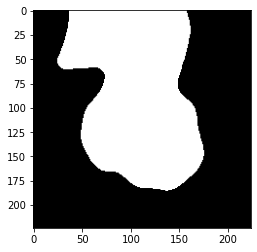

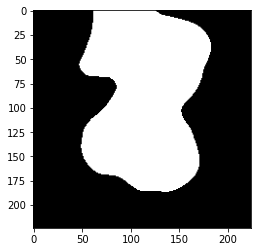

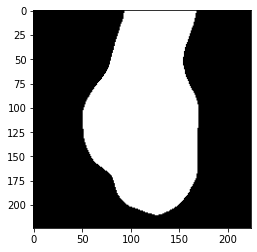

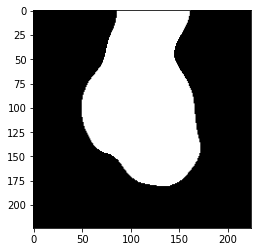

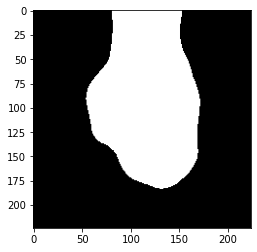

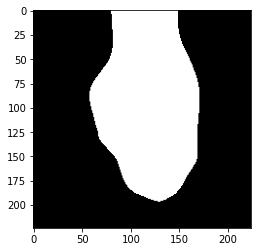

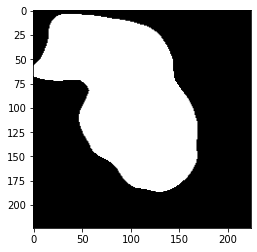

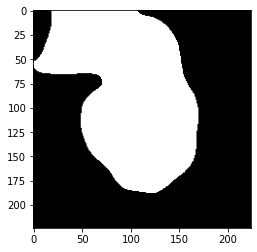

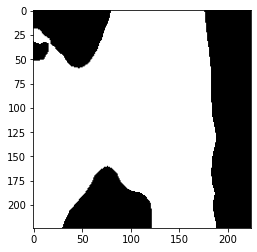

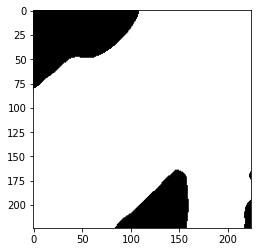

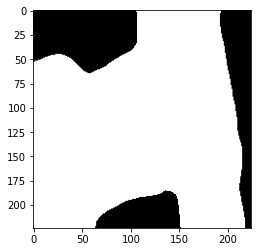

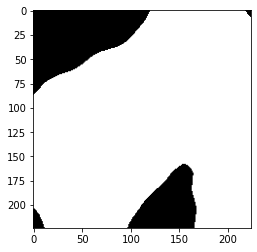

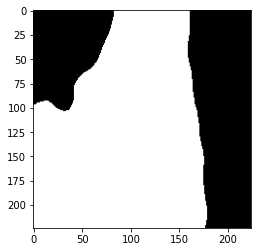

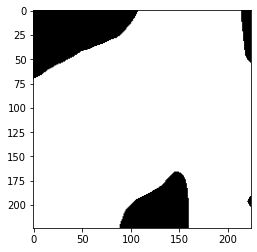

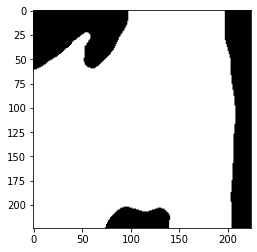

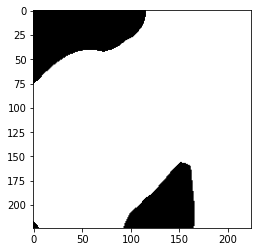

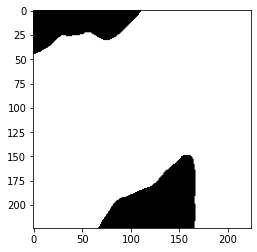

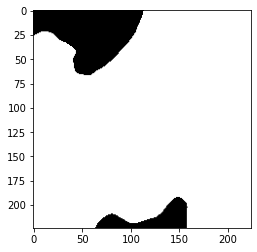

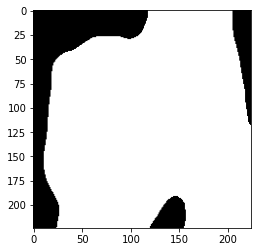

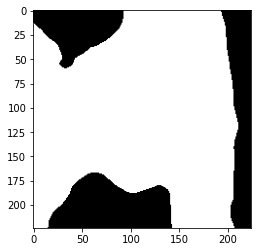

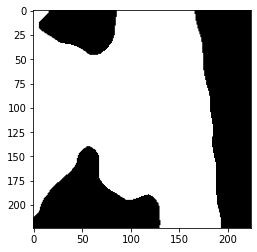

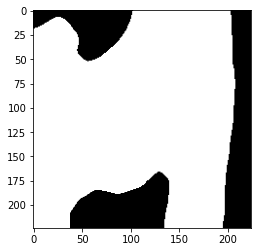

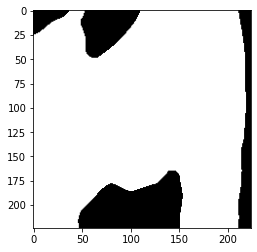

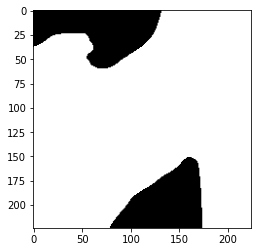

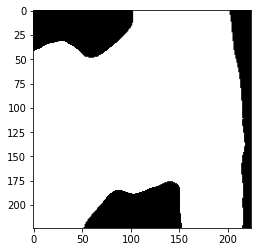

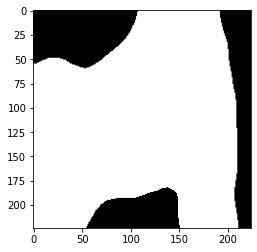

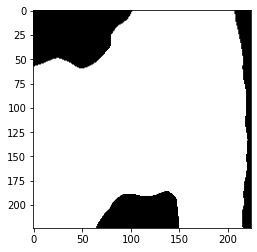

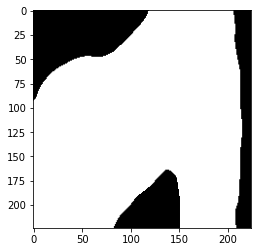

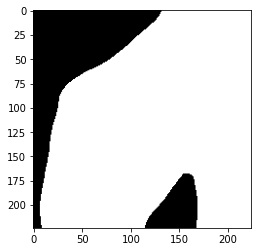

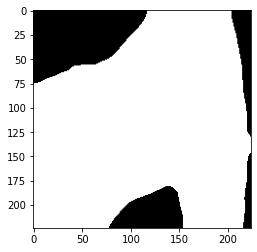

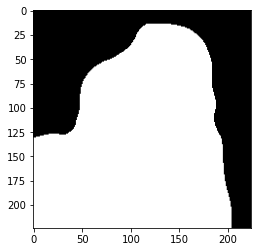

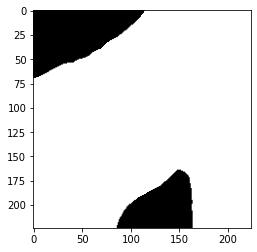

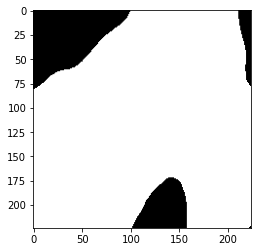

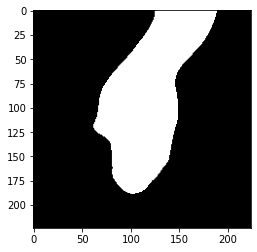

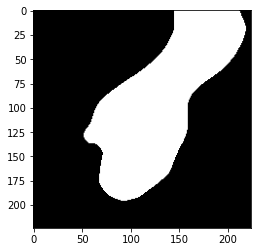

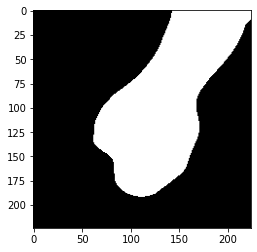

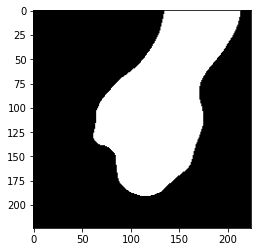

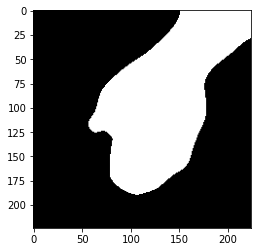

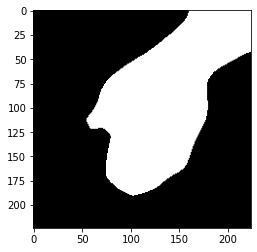

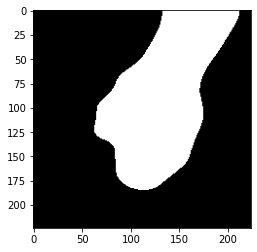

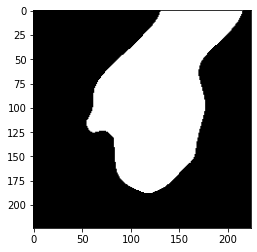

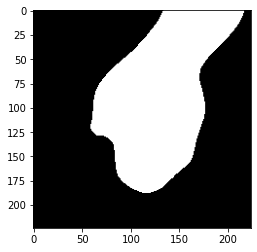

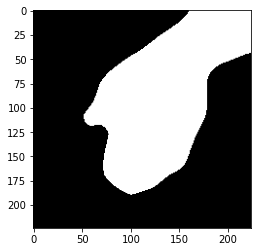

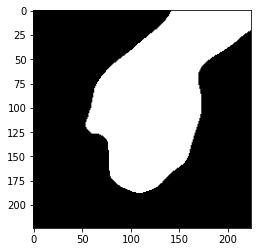

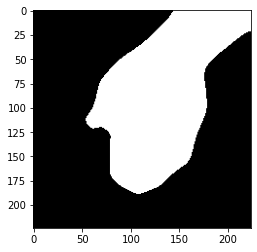

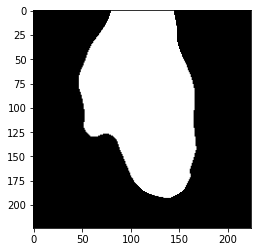

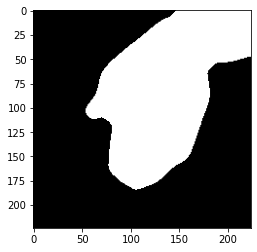

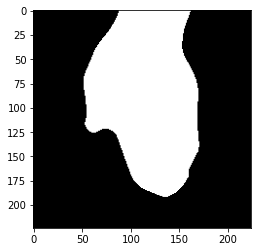

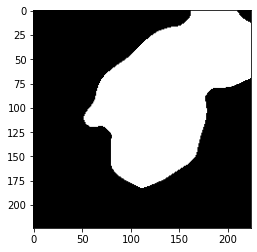

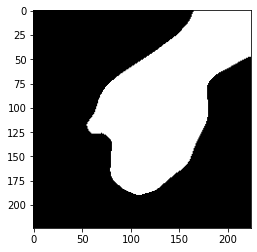

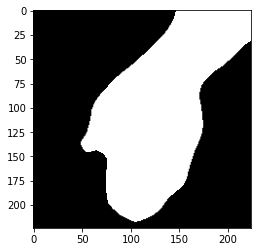

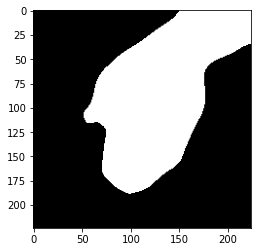

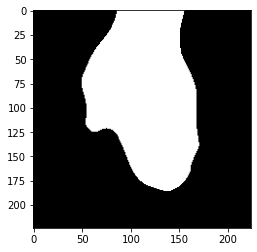

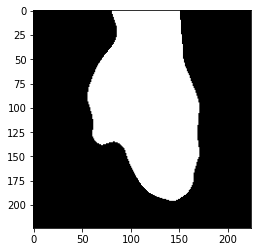

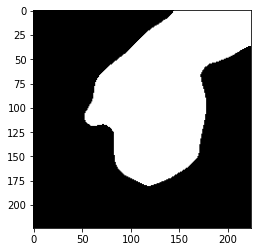

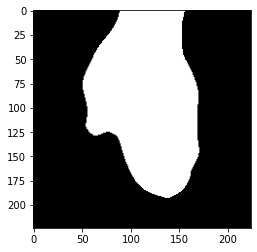

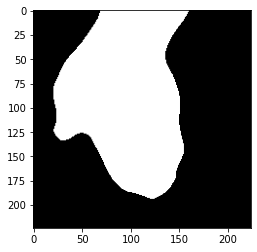

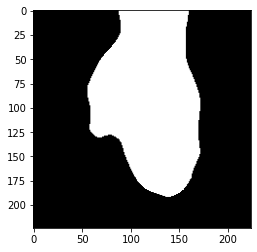

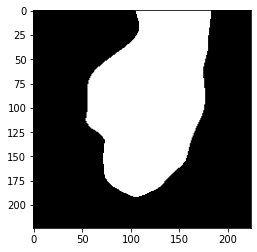

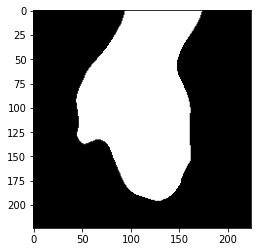

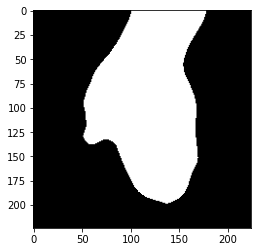

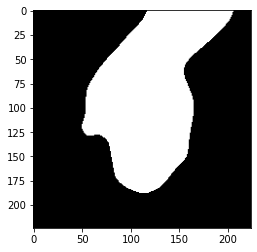

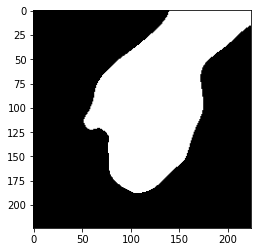

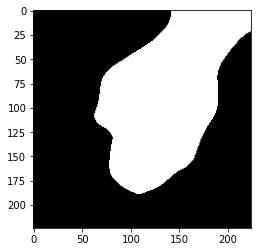

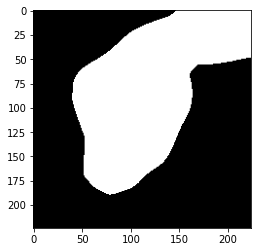

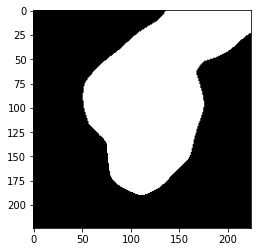

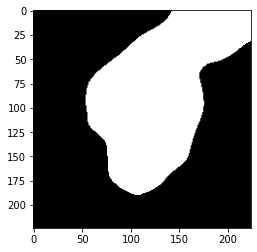

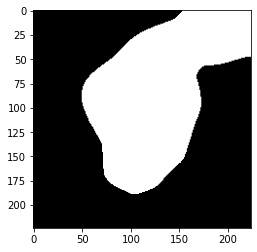

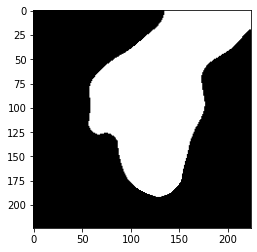

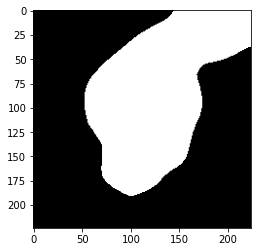

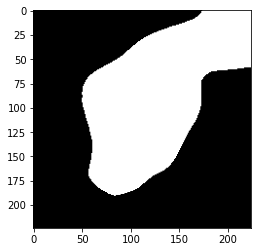

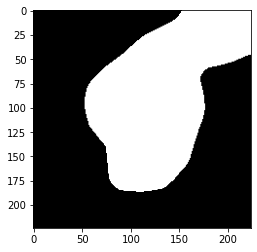

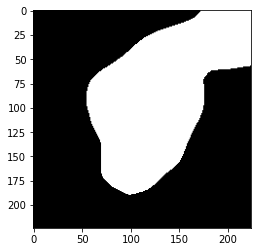

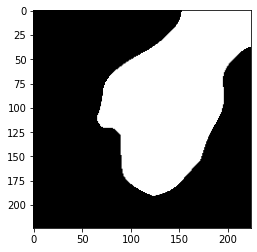

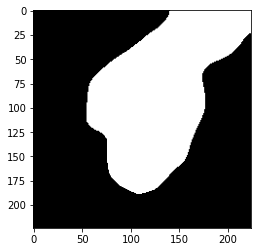

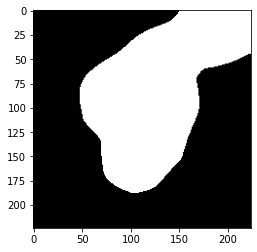

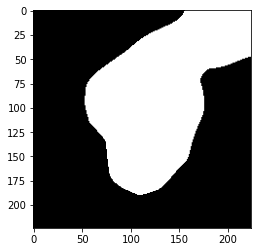

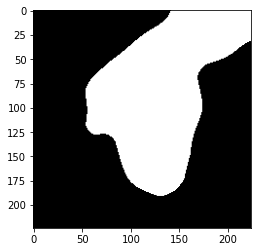

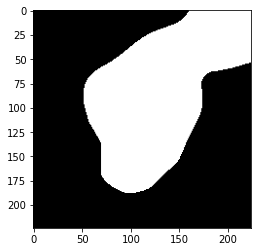

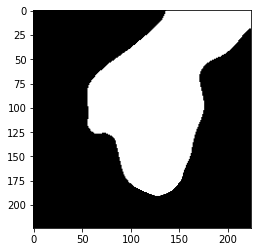

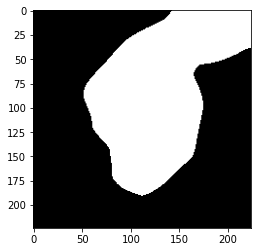

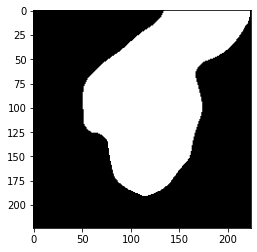

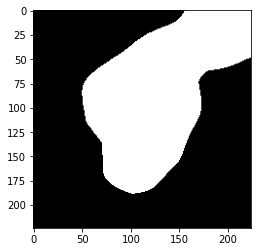

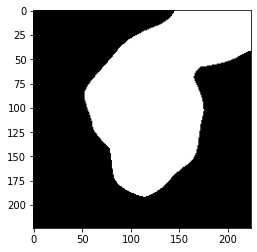

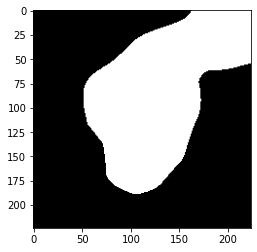

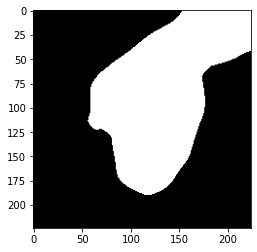

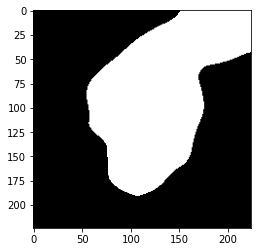

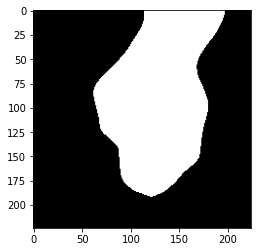

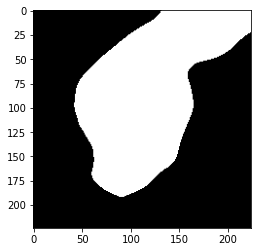

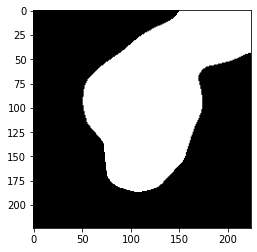

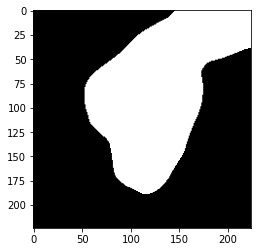

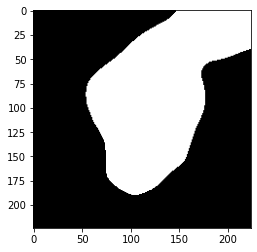

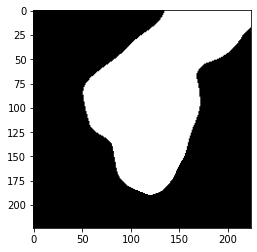

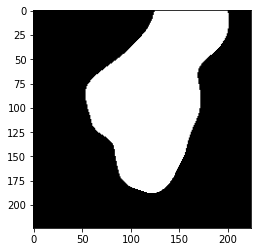

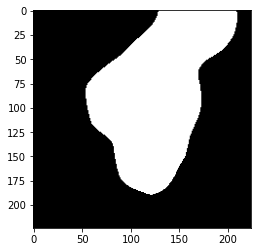

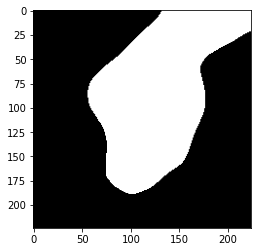

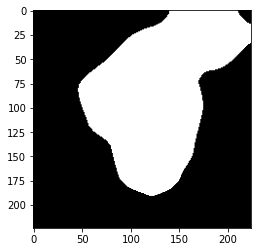

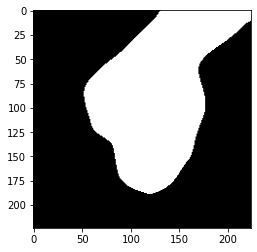

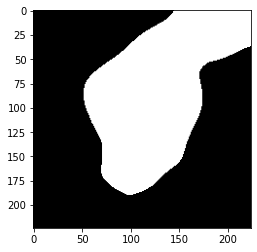

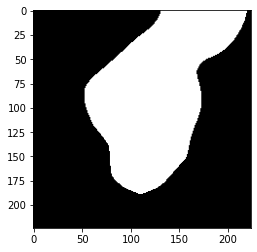

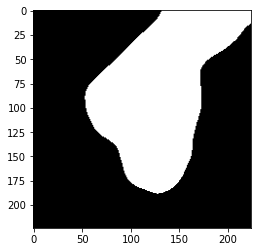

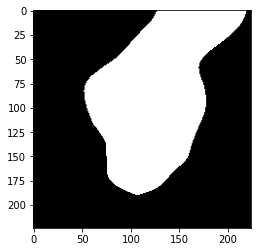

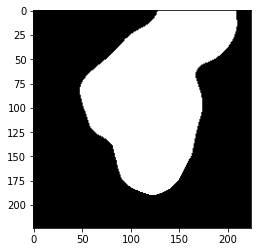

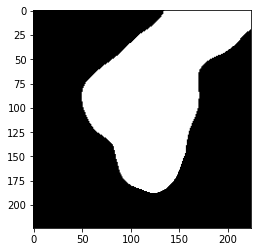

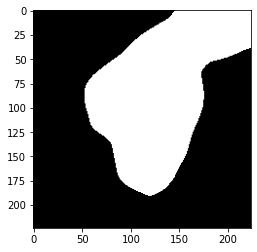

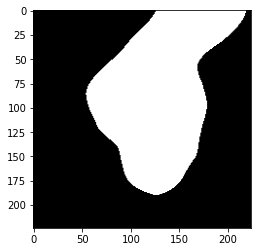

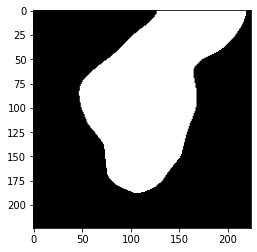

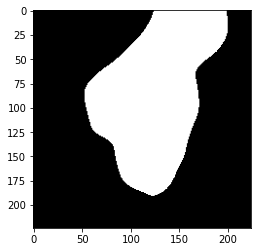

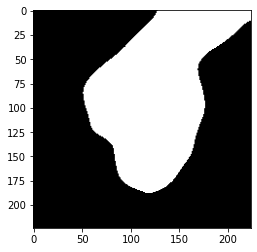

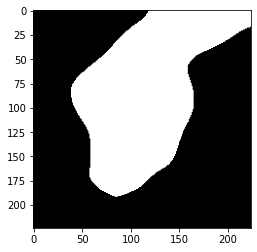

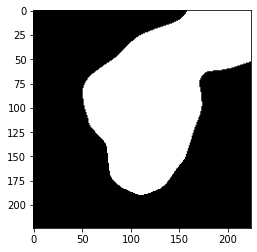

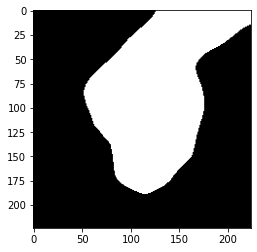

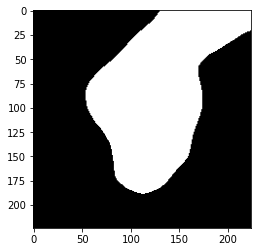

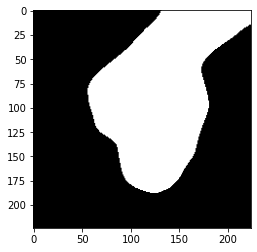

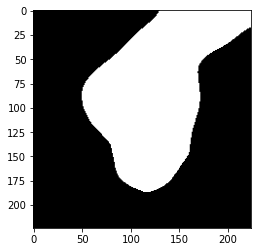

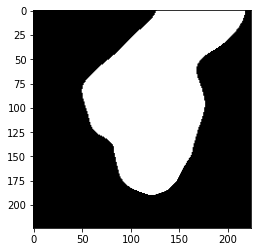

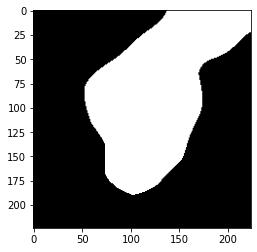

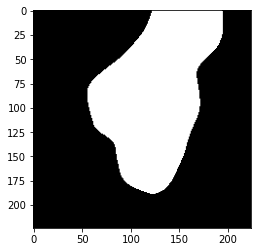

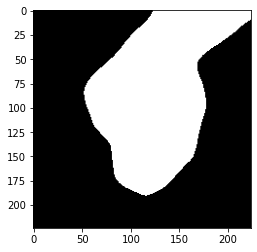

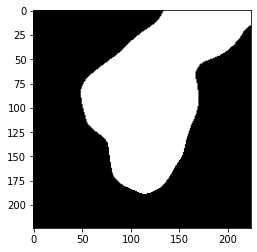

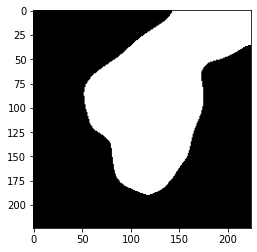

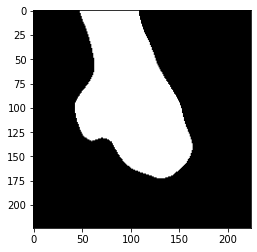

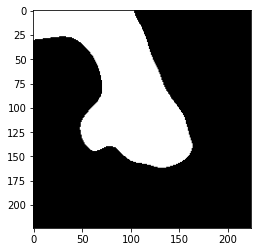

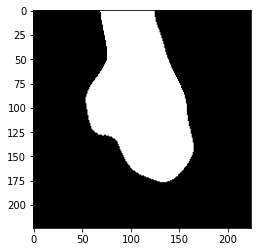

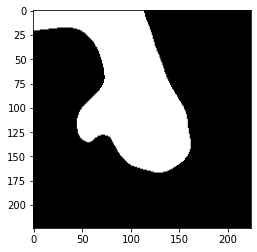

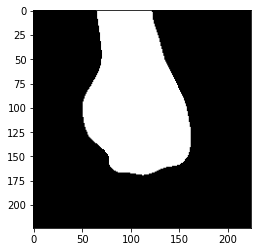

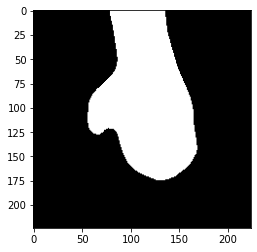

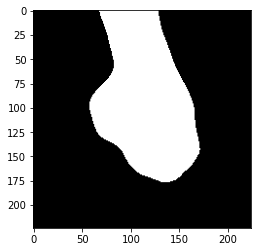

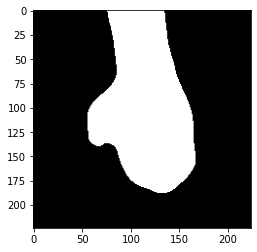

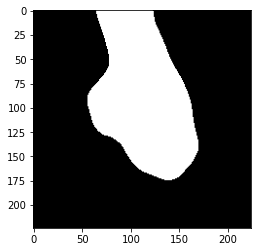

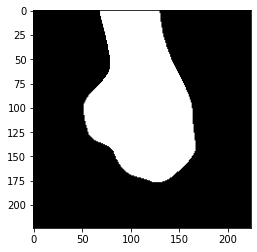

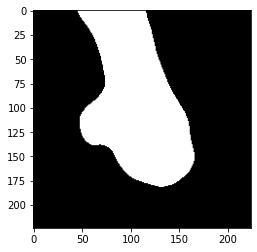

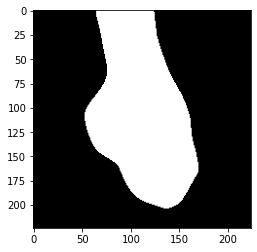

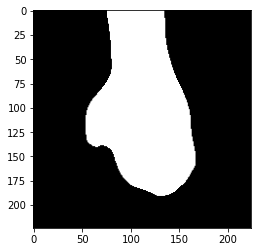

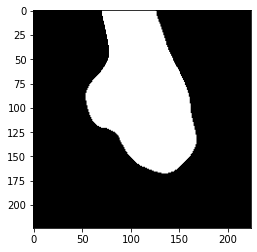

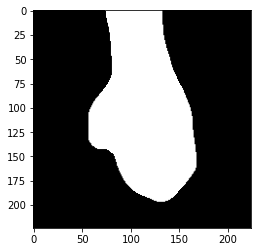

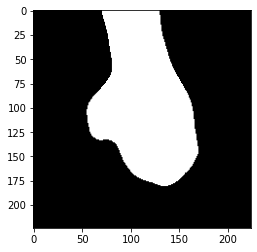

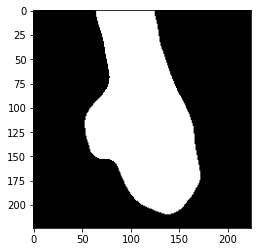

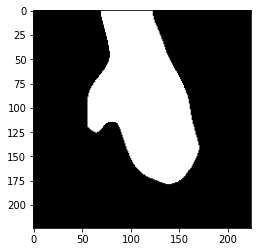

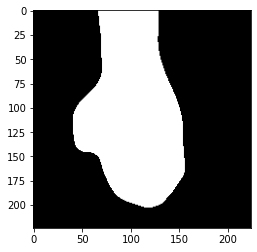

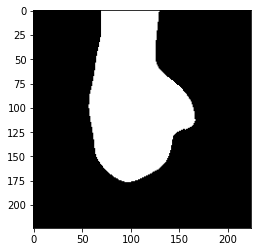

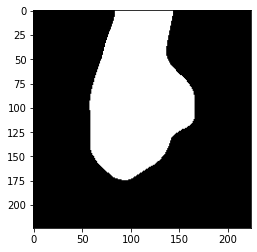

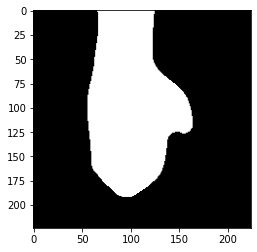

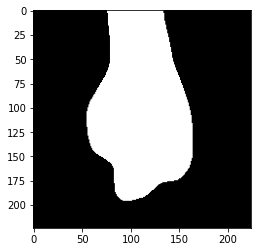

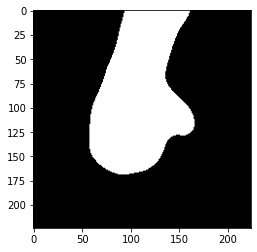

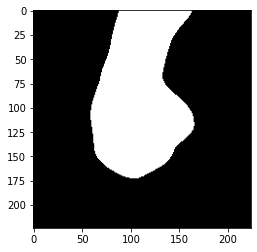

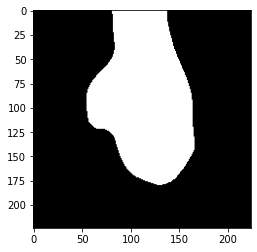

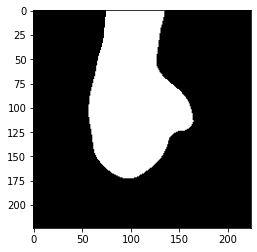

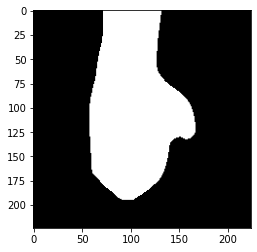

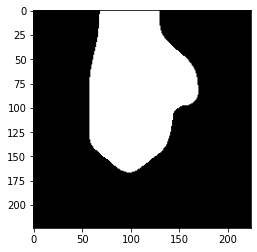

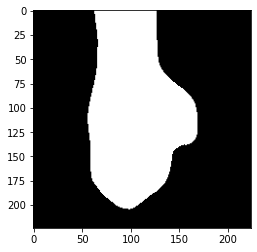

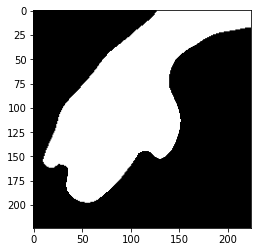

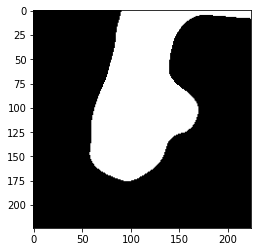

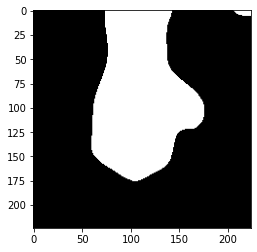

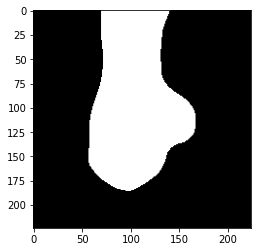

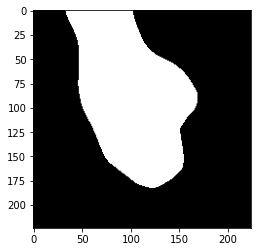

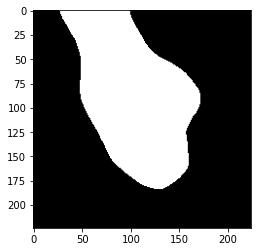

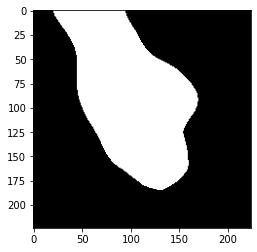

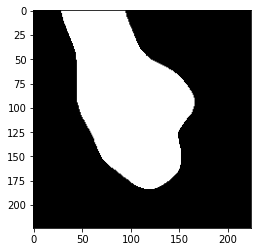

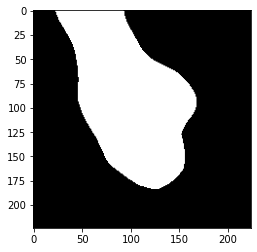

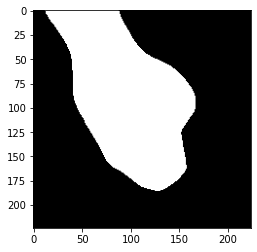

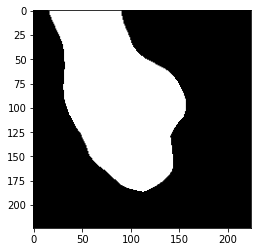

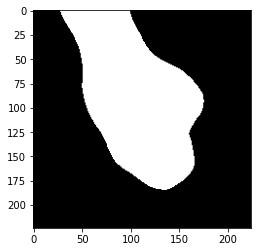

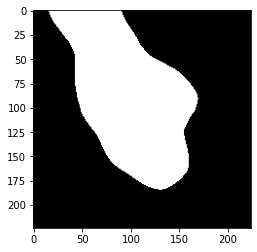

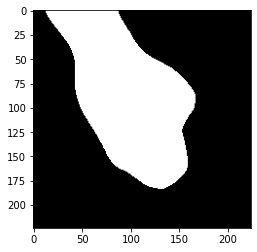

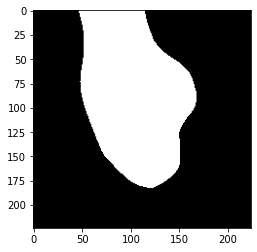

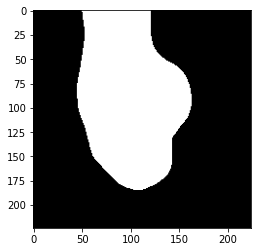

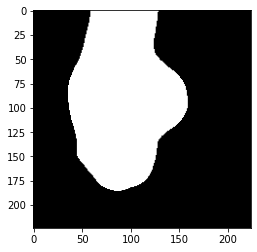

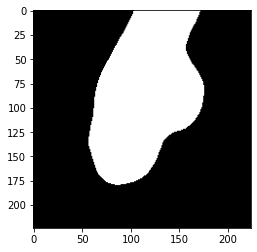

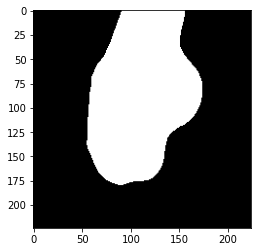

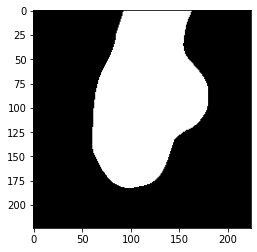

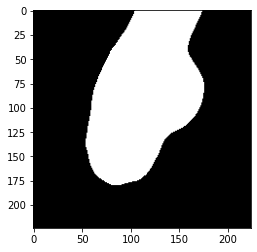

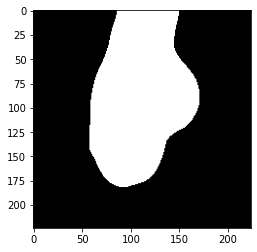

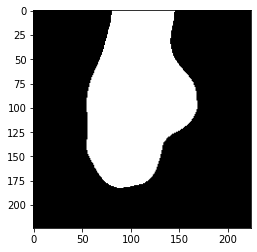

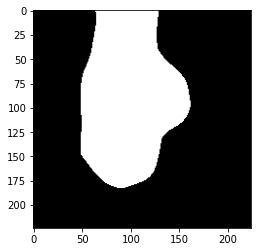

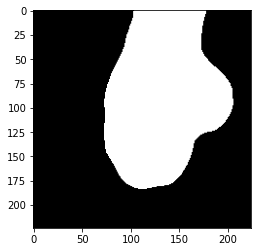

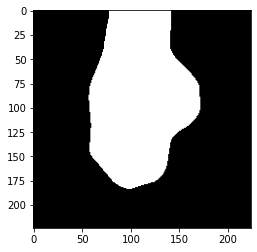

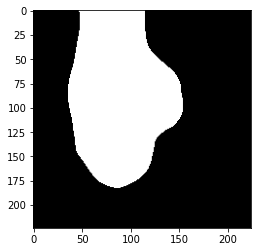

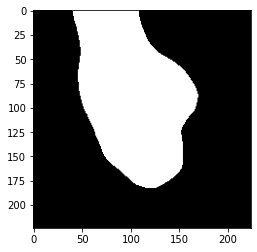

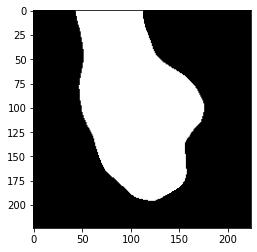

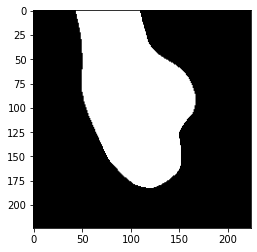

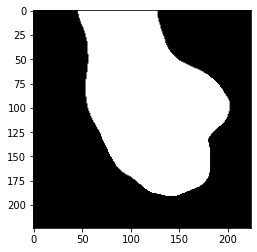

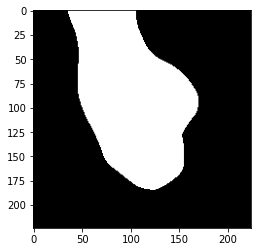

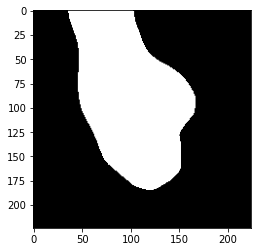

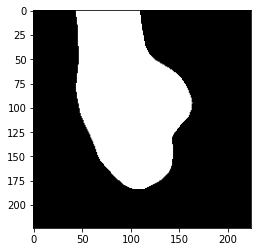

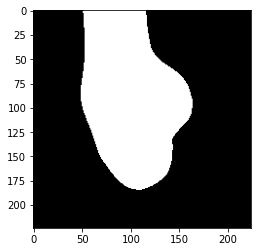

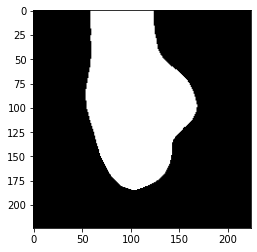

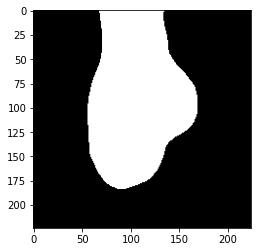

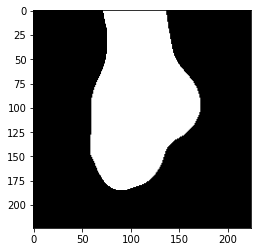

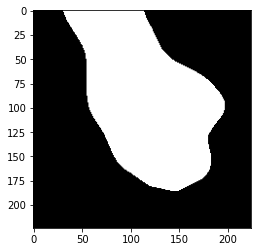

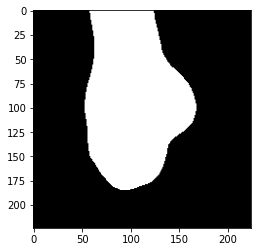

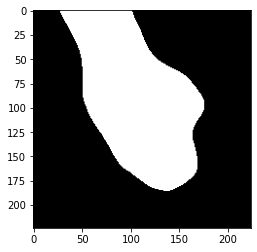

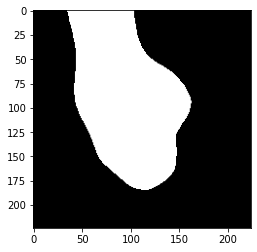

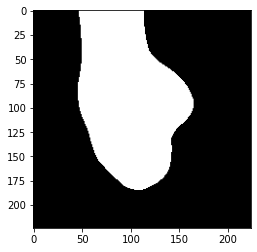

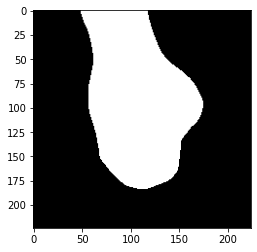

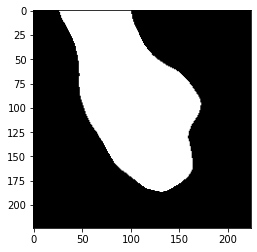

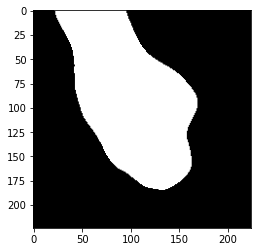

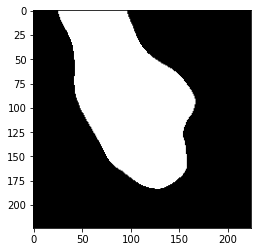

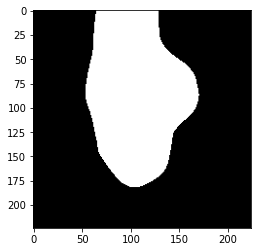

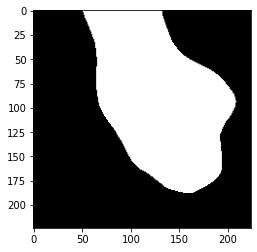

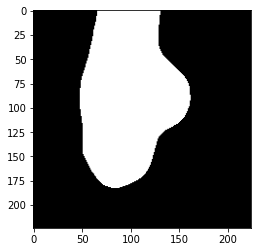

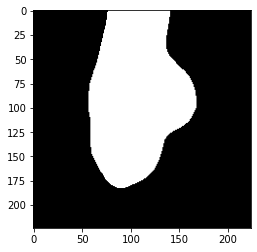

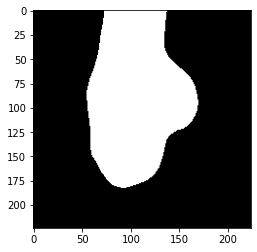

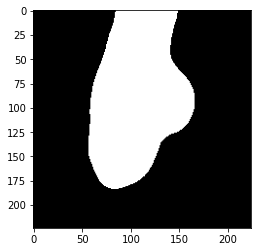

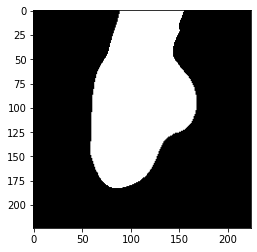

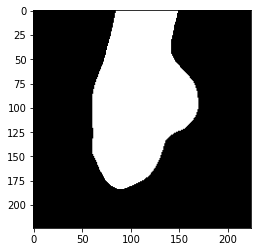

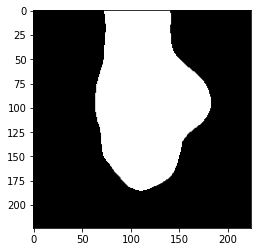

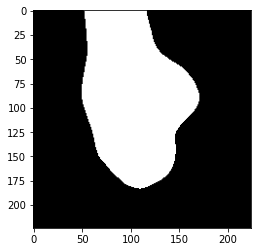

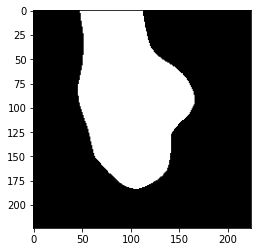

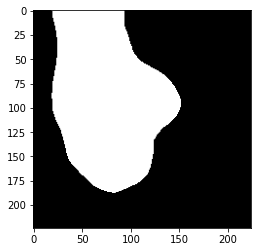

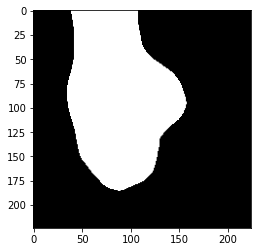

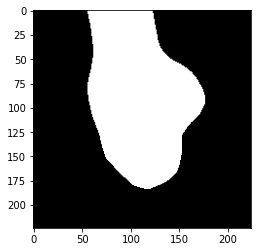

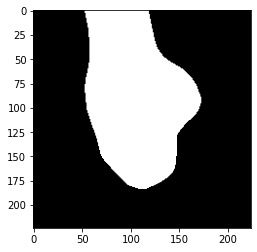

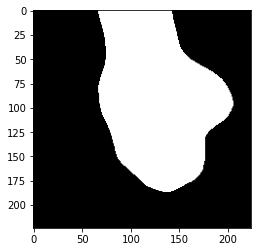

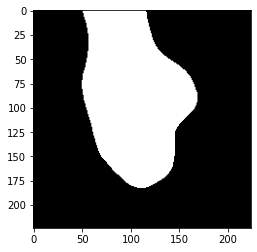

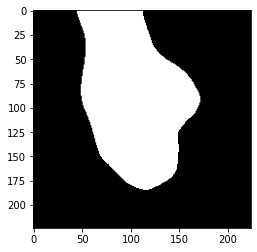

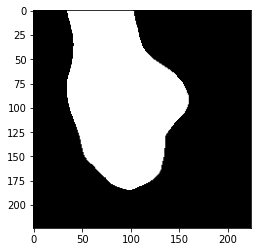

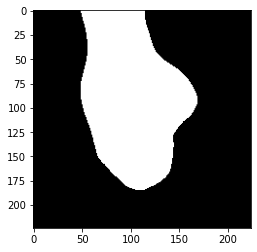

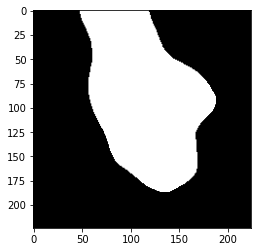

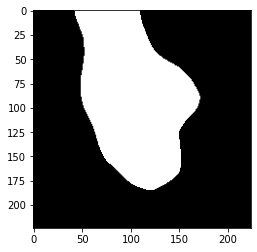

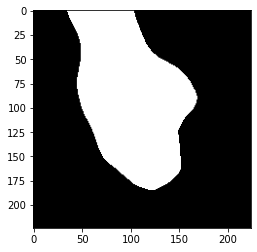

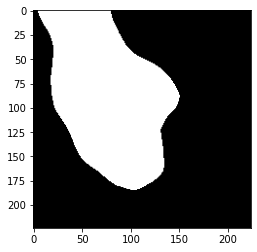

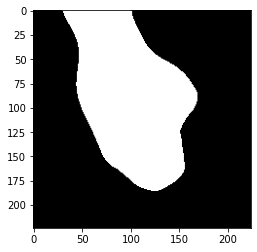

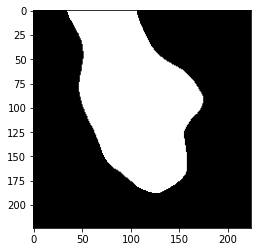

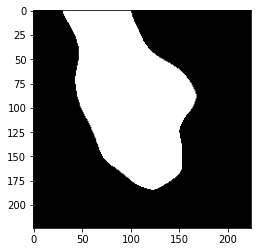

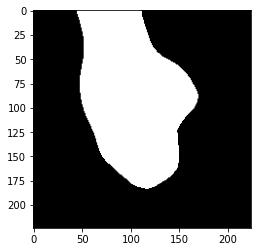

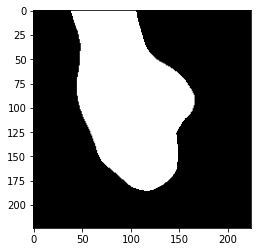

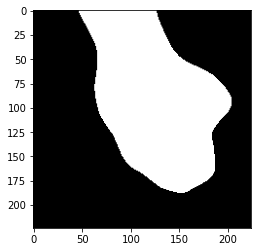

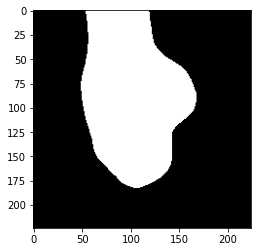

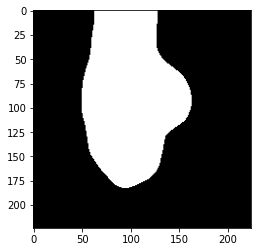

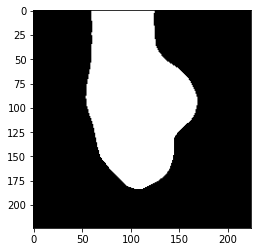

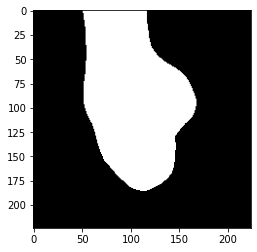

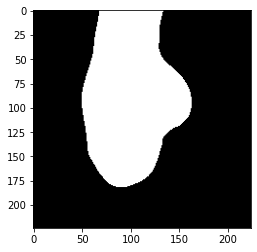

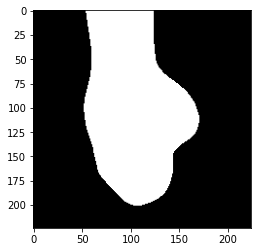

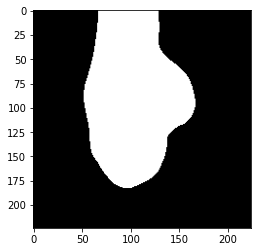

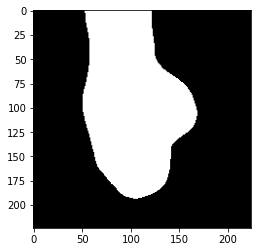

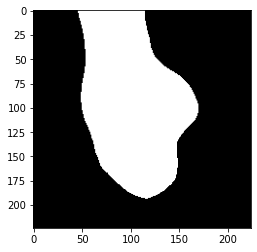

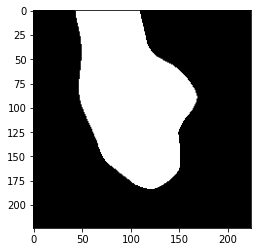

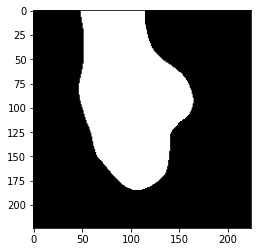

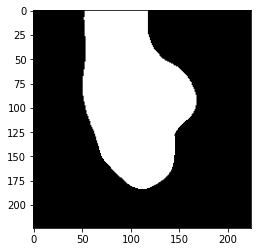

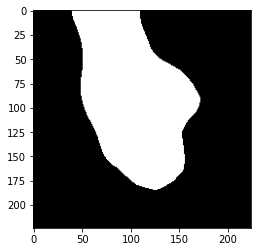

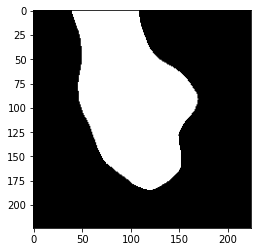

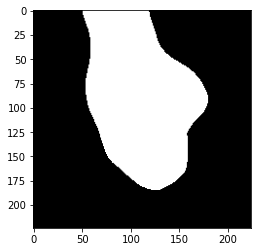

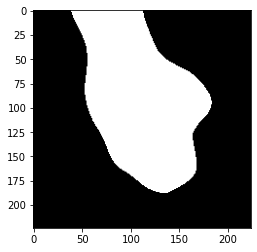

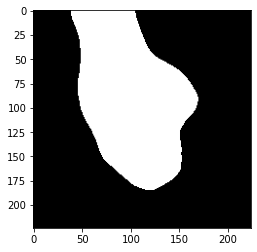

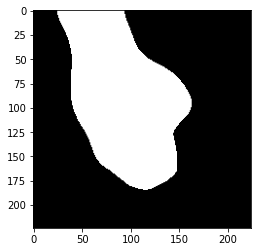

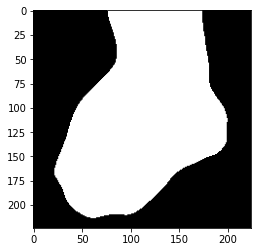

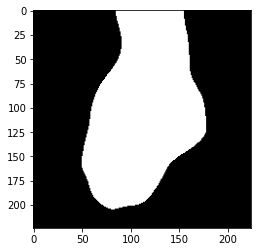

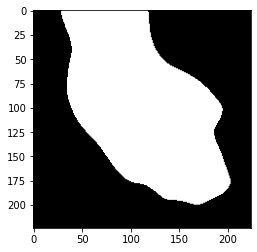

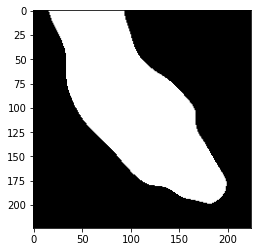

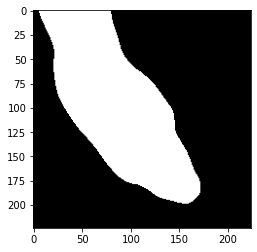

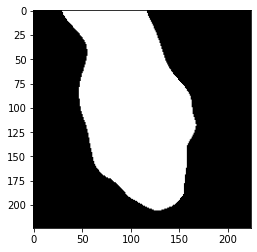

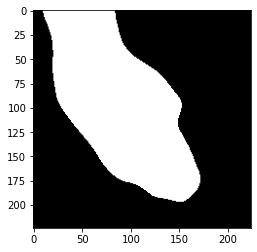

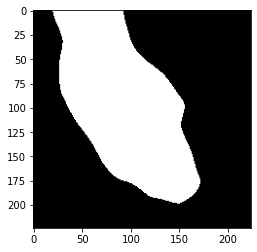

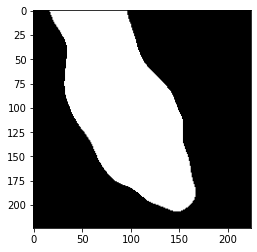

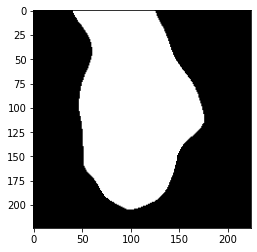

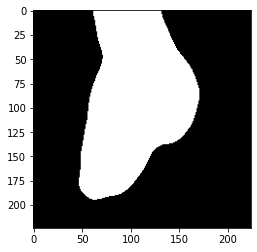

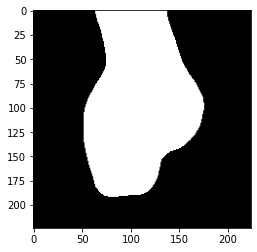

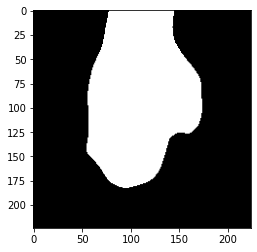

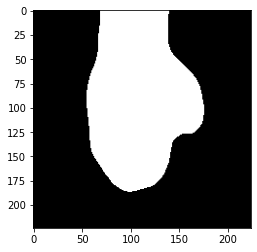

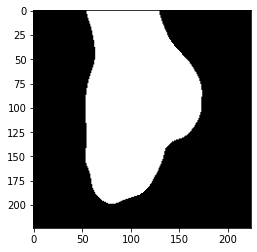

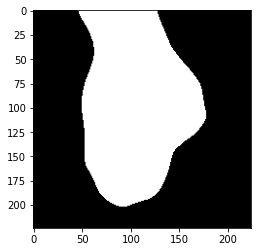

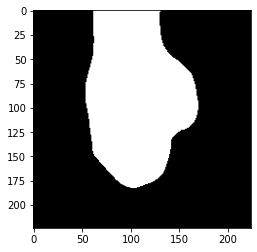

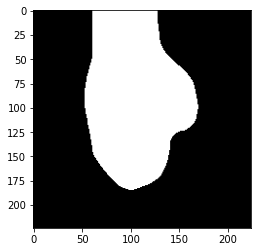

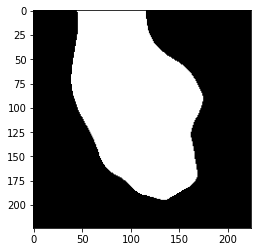

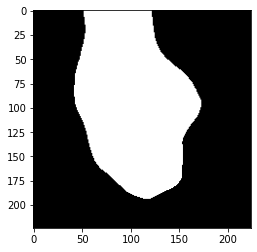

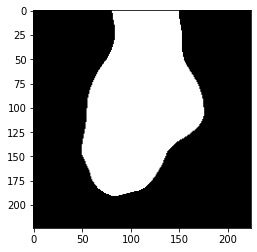

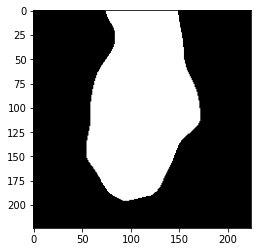

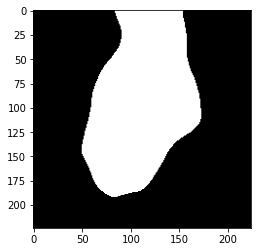

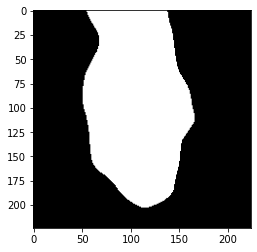

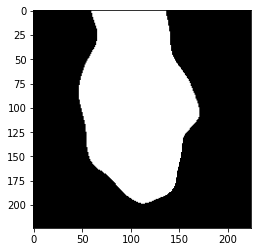

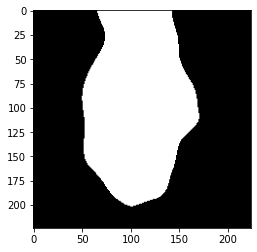

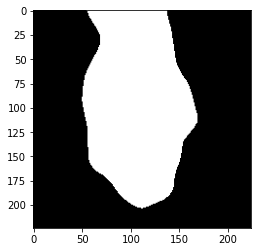

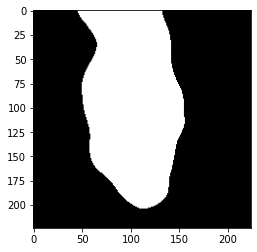

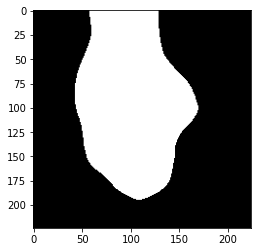

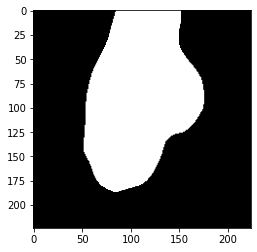

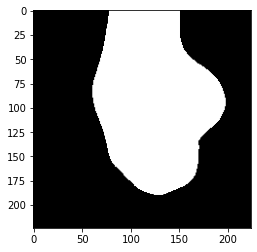

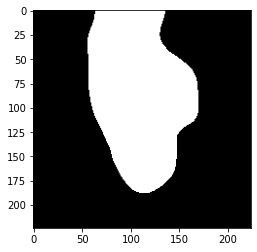

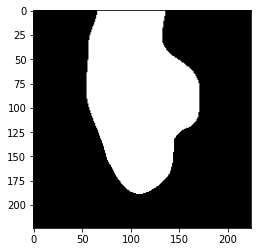

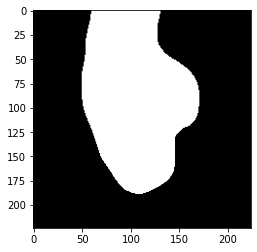

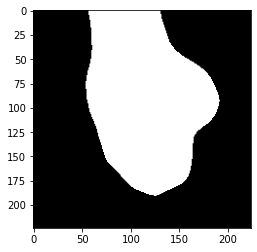

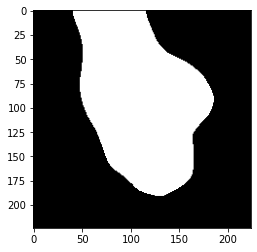

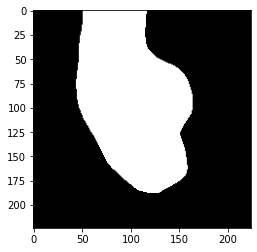

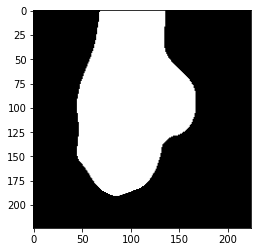

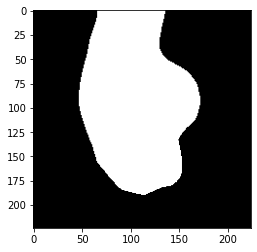

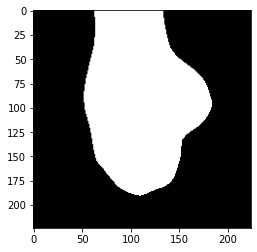

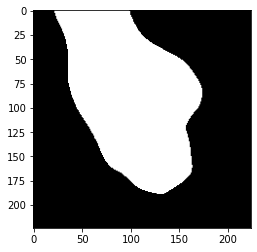

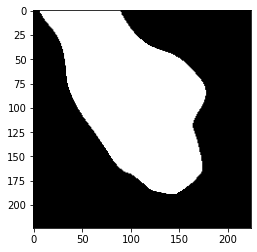

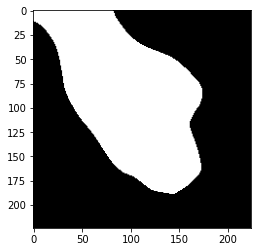

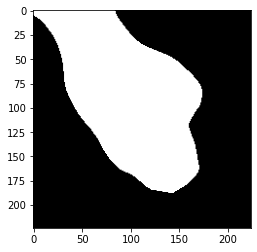

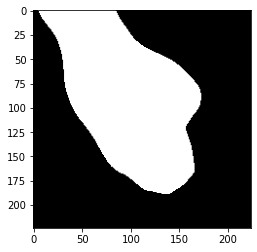

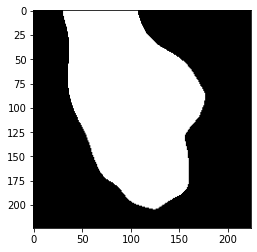

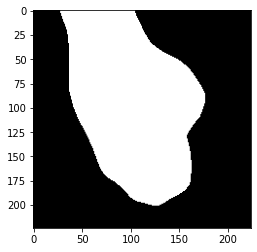

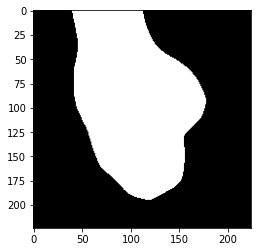

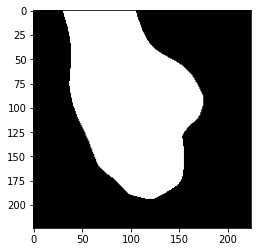

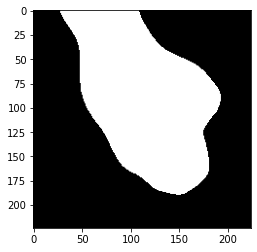

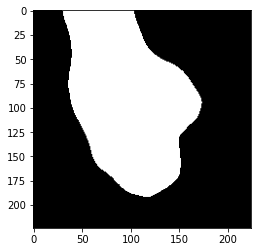

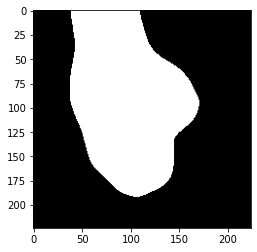

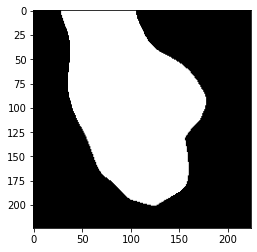

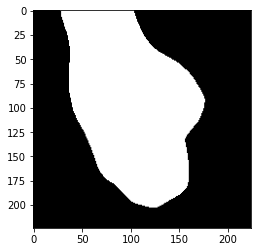

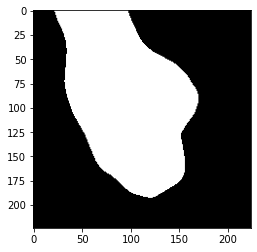

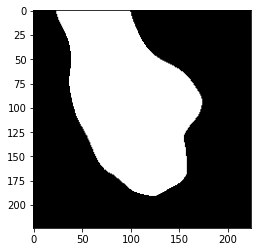

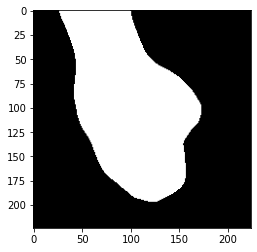

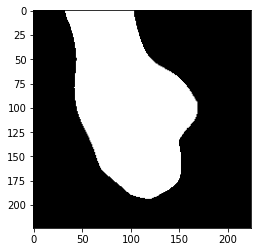

In [ ]:
# Dynamic Single
dataset_raw_ds = os.path.join(dataset_raw, 'Dynamic Single')
dataset_raw_preprocessed_ds = os.path.join(dataset_preprocessed, 'Dynamic Single')
for sign in dynamic_single:
  path_class = os.path.join(dataset_raw_ds, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_ds, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

In [ ]:
# Dynamic Double
dataset_raw_dd = os.path.join(dataset_raw, 'Dynamic Double')
dataset_raw_preprocessed_dd = os.path.join(dataset_preprocessed, 'Dynamic Double')
for sign in dynamic_double:
  path_class = os.path.join(dataset_raw_dd, sign)
  path_class_renamed = os.path.join(dataset_raw_preprocessed_dd, sign)
  i = 0
  for item in os.listdir(path_class):
    img = cv2.imread(os.path.join(path_class, item))
    detected, pts_upper_left, pts_lower_right = detector.find_hands(img)
    if detected:
      file_name = sign + "_" + str(i) + ".jpg"
      roi = img[abs(int(pts_lower_right[1])):abs(int(pts_upper_left[1])), abs(int(pts_upper_left[0])):abs(int(pts_lower_right[0]))]
      roi = resize_image(roi)
      roi = skin_segmentation(roi)
      roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
      cv2.imwrite(os.path.join(path_class_renamed, file_name), roi)
      i += 1

# Verify folders
Count the total number of images in the experiment and raw dataset folders


## Raw Dataset Folder

In [ ]:
# Letters
dataset_raw_letters = os.path.join(dataset_raw, 'Letters')
count_items(dataset_raw_letters, letters)

A 259
B 207
C 222
D 218
E 230
F 225
G 217
H 228
I 222
J 255
K 233
L 261
M 229
N 216
O 219
P 227
Q 220
R 212
S 230
T 220
U 219
V 214
W 210
X 231
Y 226
Z 0


In [ ]:
# Numbers
dataset_raw_numbers = os.path.join(dataset_raw, 'Numbers')
count_items(dataset_raw_numbers, numbers)

1 253
2 248
3 247
4 241
5 225
6 245
7 237
8 234
9 257


In [ ]:
# Static Single
dataset_raw_ss = os.path.join(dataset_raw, 'Static Single')
# pathss = '/content/drive/MyDrive/Colab Notebooks/Datasets/OurDataset/Raw_Dataset/Static Single/FINE'
count_items(dataset_raw_ss, static_single)

Fine 279
Gabi 350
Good 475
Hapon 342
He-She 383
His-Her 367
I Love You 579
I-Me 367
Mine 322
Tanghali 216
Umaga 213
You 471
Your 230


In [ ]:
# Static Double
dataset_raw_sd = os.path.join(dataset_raw, 'Static Double')
count_items(dataset_raw_sd, static_double)

Congratulations 378
Great 327
Help 254
Meet 232
Table 418
Name 230
Occupation 206
Pray 209
Rest 242
Pen 349
Stand 228
Study 233
To 290
Chair 471


In [ ]:
# Dynamic Single
dataset_raw_ds = os.path.join(dataset_raw, 'Dynamic Single')
count_items(dataset_raw_ds, dynamic_single)

Eroplano 262
Eroplano-2 366
Invite 232
Late 455
Late-2 387
No 248
No-2 270
Our 257
Our-2 363
Sorry 453
That 255
Them 293
This 305
We 397
Welcome 237
Welcome-2 221
When 220
Who 232
Who-2 246
Why 244
Why-2 319
Yes 289
Yesterday 251


In [ ]:
# Dynamic Double
dataset_raw_dd = os.path.join(dataset_raw, 'Dynamic Double')
count_items(dataset_raw_dd, dynamic_double)

Ago 500
Allow 237
Ball 328
Banana 329
Banana-2 211
Bread 380
Break 208
Egg 283
Break-2 233
Bring 222
Bring-2 251
Buy 250
Buy-2 256
Bye 219
Coconut 341
Egg-2 213
Coffee 304
Come 220
Come-2 267
Cook 228
From 230
From-2 208
Get 216
Get-2 276
Egg-3 212
Go 229
Go-2 237
Happen 217
Happen-2 223
How 223
How-2 247
Introduce 255
Introduce-2 218
Let 217
Let-2 247
Live 253
Mango 312
Maybe 289
Nice 238
Now 262
Office 312
Office-2 369
School 348
Sit 341
Store 409
Strawberry 352
Thank You 272
Thank You-2 261
Today 272
Today-2 236
What 240
Where 232
Which 259
Work 244
Year 421


## Dataset Preprocessed Folder

In [ ]:
# Letters
dataset_raw_preprocessed_letters = os.path.join(dataset_preprocessed, 'Letters')
count_items(dataset_raw_preprocessed_letters, letters)

A 246
B 314
C 200
D 214
E 301
F 214
G 204
H 309
I 201
J 211
K 223
L 254
M 213
N 202
O 210
P 201
Q 247
R 203
S 219
T 203
U 212
V 205
W 201
X 220
Y 214
Z 0


In [ ]:
# Numbers
dataset_raw_preprocessed_number = os.path.join(dataset_preprocessed, 'Numbers')
count_items(dataset_raw_preprocessed_number, numbers)

1 234
2 227
3 233
4 220
5 214
6 229
7 223
8 219
9 239


In [ ]:
# Static Single
dataset_raw_preprocessed_ss = os.path.join(dataset_preprocessed, 'Static Single')
count_items(dataset_raw_preprocessed_ss, static_single)

Fine 272
Gabi 281
Good 403
Hapon 241
He-She 221
His-Her 225
I Love You 382
I-Me 352
Mine 286
Tanghali 212
Umaga 212
You 446
Your 227


In [ ]:
# Static Double
dataset_raw_preprocessed_sd = os.path.join(dataset_preprocessed, 'Static Double')
count_items(dataset_raw_preprocessed_sd, static_double)

Congratulations 234
Great 643
Help 521
Meet 456
Table 202
Name 590
Occupation 431
Pray 461
Rest 208
Pen 629
Stand 520
Study 677
To 204
Chair 405


In [ ]:
# Dynamic Single
dataset_raw_preprocessed_ds = os.path.join(dataset_preprocessed, 'Dynamic Single')
count_items(dataset_raw_preprocessed_ds, dynamic_single)

Eroplano 218
Eroplano-2 241
Invite 438
Late 238
Late-2 366
No 216
No-2 246
Our 214
Our-2 252
Sorry 375
That 213
Them 219
This 211
We 328
Welcome 214
Welcome-2 433
When 203
Who 224
Who-2 218
Why 203
Why-2 267
Yes 240
Yesterday 229


In [ ]:
# Dynamic Double
dataset_raw_preprocessed_dd = os.path.join(dataset_preprocessed, 'Dynamic Double')
count_items(dataset_raw_preprocessed_dd, dynamic_double)

Ago 397
Allow 823
Ball 216
Banana 466
Banana-2 325
Bread 490
Break 332
Egg 215
Break-2 539
Bring 277
Bring-2 469
Buy 414
Buy-2 278
Bye 648
Coconut 733
Egg-2 460
Coffee 601
Come 283
Come-2 336
Cook 450
From 503
From-2 462
Get 585
Get-2 221
Egg-3 303
Go 555
Go-2 448
Happen 401
Happen-2 354
How 388
How-2 621
Introduce 577
Introduce-2 524
Let 306
Let-2 239
Live 278
Mango 226
Maybe 574
Nice 185
Now 199
Office 221
Office-2 321
School 243
Sit 284
Store 266
Strawberry 260
Thank You 234
Thank You-2 417
Today 293
Today-2 559
What 199
Where 268
Which 611
Work 594
Year 196


## Move Dataset from unsorted to preprocessed

In [ ]:
new_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Unsorted'

In [ ]:
for item in os.listdir(new_dataset_path):
  folder = os.path.join(new_dataset_path, item)
  print(item + "\t\t", len(os.listdir(folder)))

Ago		 0
Allow		 0
Banana		 0
Banana-2		 0
Bread		 0
Break		 0
Break-2		 0
Bring		 0
Bring-2		 0
Buy		 0
Buy-2		 0
Bye		 0
Coconut		 0
Coffee		 0
Come		 0
Cook		 0
D		 0
Egg-2		 0
From		 0
From-2		 0
Get		 0
Go		 0
Go-2		 0
Great		 0
Happen		 0
Happen-2		 0
Help		 0
How		 0
How-2		 0
Introduce		 0
Introduce-2		 0
Invite		 0
Let		 0
Maybe		 0
Let-2		 0
Meet		 0
Name		 0
Nice		 0
Occupation		 0
Pen		 0
Pray		 0
Q		 0
Stand		 0
Study		 0
Thank You-2		 0
Today-2		 0
Welcome-2		 0
Where		 0
Which		 0
Work		 0
B		 0
Egg-3		 0
H		 0
Live		 0
Chair		 0
Come-2		 0
E		 0
Today		 0


In [ ]:
letters = ['B', 'D', 'E', 'H', 'Q']
letters_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Preprocessed_Raw_Dataset/Letters'
for item in os.listdir(new_dataset_path):
  if item in letters:
    class_path = os.path.join(new_dataset_path, item)
    os.chdir(class_path)
    for img in os.listdir(class_path):
      shutil.move(img, os.path.join(letters_path, item))

In [ ]:
dynamic_single = ['Invite', 'Welcome-2']
dynamic_single_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Preprocessed_Raw_Dataset/Dynamic Single'
for item in os.listdir(new_dataset_path):
  if item in dynamic_single:
    class_path = os.path.join(new_dataset_path, item)
    os.chdir(class_path)
    for img in os.listdir(class_path):
      shutil.move(img, os.path.join(dynamic_single_path, item))

In [ ]:
static_double = ['Chair', 'Study', 'Stand', 'Pen', 'Pray', 'Occupation', 'Name', 'Meet', 'Help', 'Great']
static_double_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Preprocessed_Raw_Dataset/Static Double'
for item in os.listdir(new_dataset_path):
  if item in static_double:
    class_path = os.path.join(new_dataset_path, item)
    os.chdir(class_path)
    for img in os.listdir(class_path):
      shutil.move(img, os.path.join(static_double_path, item))

In [ ]:
dynamic_double = ['Ago', 'Allow', 'Banana', 'Banana-2', 'Bread', 'Break', 'Break-2', 'Bring', 'Bring-2', 'Buy', 'Buy-2', 'Bye', 'Coconut', 'Coffee', 'Come', 'Come-2',
                  'Cook', 'Egg-2', 'Egg-3', 'From', 'From-2', 'Get', 'Get-2', 'Go', 'Go-2', 'Happen', 'Happen-2', 'How', 'How-2', 'Introduce', 'Introduce-2',
                  'Let', 'Let-2', 'Live', 'Maybe', 'Nice', 'Thank You', 'Today', 'Today-2', 'Where', 'Which', 'Work']

In [ ]:
dynamic_double = ['Thank You-2', 'Where', 'From-2']

In [ ]:
dynamic_double_path = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Preprocessed_Raw_Dataset/Dynamic Double'
for item in os.listdir(new_dataset_path):
  if item in dynamic_double:
    class_path = os.path.join(new_dataset_path, item)
    os.chdir(class_path)
    for img in os.listdir(class_path):
      shutil.move(img, os.path.join(dynamic_double_path, item))
# print(len(dynamic_double))

In [ ]:
import os
from os import listdir
from PIL import Image


categ = ['Train', 'Valid', 'Test']
dataset = '/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset'

for cat in categ:
  img_path = os.path.join(dataset, cat)
  for foldername in listdir(img_path):
    sign_path = os.path.join(img_path, foldername)
    print(sign_path)
    for sign in listdir(sign_path):
      if sign.endswith('.jpg'):
        try:
          img = Image.open(os.path.join(sign_path, sign)) # open the image file
          img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
          print('Bad file:', sign) # print out the names of corrupt files

/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/A
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/B
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/C
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/D
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/E
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/F
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/G
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/H
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/I
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/J
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/K
/content/drive/MyDrive/Colab Notebooks/Datasets/FSLR_Application_Dataset/Train/L
/content/drive/MyDrive/Colab